# Geo-Experimentation via Time Based Regression in PyMC

## Introduction

In this notebook I describe and present an implementation of the **time based regression** (TBR) approach to marketing campaign analysis in the context of geo experimentation presented in the paper [Estimating Ad Effectiveness using Geo Experiments in a Time-Based Regression Framework](https://research.google/pubs/pub45950/) by Jouni Kerman, Peng Wang and  Jon Vaver (Google, Inc. 2017). I strongly recommend reading the paper as it is quite clear in the exposition of the approach and presents some simulation results. Here I will focus on the basic model specification and on the implementation in PyMC.

## The Data

The motivating example of this case is study was presented in the talk I gave at the [Helsinki Data Science Meetup](https://dainstudios.com/event/data-science-at-wolt/) hosted by **Wolt**. [Here](https://juanitorduz.github.io/wolt_ds_meetup/) you can find the recording of the talk and the data generating process. [Here](https://raw.githubusercontent.com/juanitorduz/website_projects/master/data/zipcodes_data.csv) you can find the raw data.

We generated an artificial dataset for a geo-experiment with the following characteristics: We have a city with $40$ zip codes where we ran a marketing campaign for a subset of them (treated geos). The campaign period was $30$ days and it began at the same time. Our objective is to estimate the effect of the campaign on the number of orders.

## The Model

Let $G=\{g_1, g_2, \cdots, g_{n_{c}}, \cdots , g_{n_c + n_t}\}$ denote the set of geos (zip codes) of our city. Without loss of generality we assume that the first $n_c$ geos are part of the control group ($\mathcal{C} \subset G$)and the rest are the treated ones ($\mathcal{T} \subset G$). We would like to find a subset $\mathcal{C'} \subseteq \mathcal{C}$ of geos in he the control group which are similar to the treated ones in the pre-campaign period. In the **time based regression** model "similar" means that there is a linear relationship between the number of orders in the pre-campaign period. Concretely, if $y_{g_{i}, t}$ denotes the number of orders at time $t$ for the geo $g_i$ then we assume that

$$
\sum_{g_{i} \in \mathcal{T}} y_{g_{i}, t} = \alpha + \beta \sum_{g_{j} \in \mathcal{C'}} y_{g_{j}, t} + \varepsilon_t, \quad \text{$t$ in pretest period}
$$

where $\alpha$ is the intercept and $\beta$ the regression coefficient *which are both independent on t and the geos*. We further assume that the errors $\varepsilon_t$ are independent Normal errors with standard deviation $\sigma$. The objective is now to estimate $\alpha$, $\beta$ and $\sigma$ so that we can estimate the effect of the campaign comparing with the predicted counterfactual number of orders in the treated geos. That is, we use the fitted parameters of the model to predict the number of orders in the treated geos in the post-campaign period and compare it with the actual number of orders. The difference between the actual and the predicted number of orders is the estimated effect of the campaign. For details, please see [Section 3.2 - TBR Causal Effect Analysis](https://research.google/pubs/pub45950/) from the original paper.

## Remarks

- This approach is similar to the [CausalImpact](https://google.github.io/CausalImpact/CausalImpact.html) model by Google where a bayesian structural time series model is used to estimate the counterfactual. In practice, one os often faced with geos which are relative new and there is no enough data to estimate a time series model. In this case, the time based regression model is a good alternative (another alternative is to transfer the trend an seasonality from other geos as described in  [Modeling Short Time Series with Prior Knowledge in PyMC](https://juanitorduz.github.io/short_time_series_pymc/), but this is a bit trickier to implement for real datasets).
- One interesting feature of the paper is the uncertainty estimation. The author suggest to generate a sequence of prediction intervals by simulating artificial test sets (see [Section 4 - Design Process for TBR](https://research.google/pubs/pub45950/)). We will go through the details later in this in the notebook.
- This approach is sometimes known as *interrupted time series analysis*. A PyMC implementation is presented by [Benjamin T. Vincent](https://github.com/drbenvincent) on [this example notebook](https://www.pymc.io/projects/examples/en/latest/causal_inference/interrupted_time_series.html#interrupted-time-series-analysis) (also see the [`CausalPy`](https://github.com/pymc-labs/CausalPy) python package). Here we focus in the uncertainty estimation approach of the original paper.
- There are methods to efficiently select the geos to treat. See for example [A Time-Based Regression Matched Markets Approach for Designing Geo Experiments](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/b1976d70ccf7119f2193ece2d3d378d5dd0dd7be.pdf) with the python implementation [https://github.com/google/matched_markets](https://github.com/google/matched_markets).

Now, let's move to the concrete example.

---

## Prepare Notebook

In [1]:
import arviz as az
from datetime import datetime
from itertools import chain
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import numpy.typing as npt
import pandas as pd
import pymc as pm
import pymc.sampling_jax
from sklearn.preprocessing import StandardScaler 
import seaborn as sns
from tqdm.notebook import tqdm
from xarray import DataArray, Dataset


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/jax.py:37: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Read Data

In [2]:
data_path = "https://raw.githubusercontent.com/juanitorduz/website_projects/master/data/zipcodes_data.csv"

data_df = pd.read_csv(data_path, parse_dates=["date"])

Let's take a look at the data for each zip code:

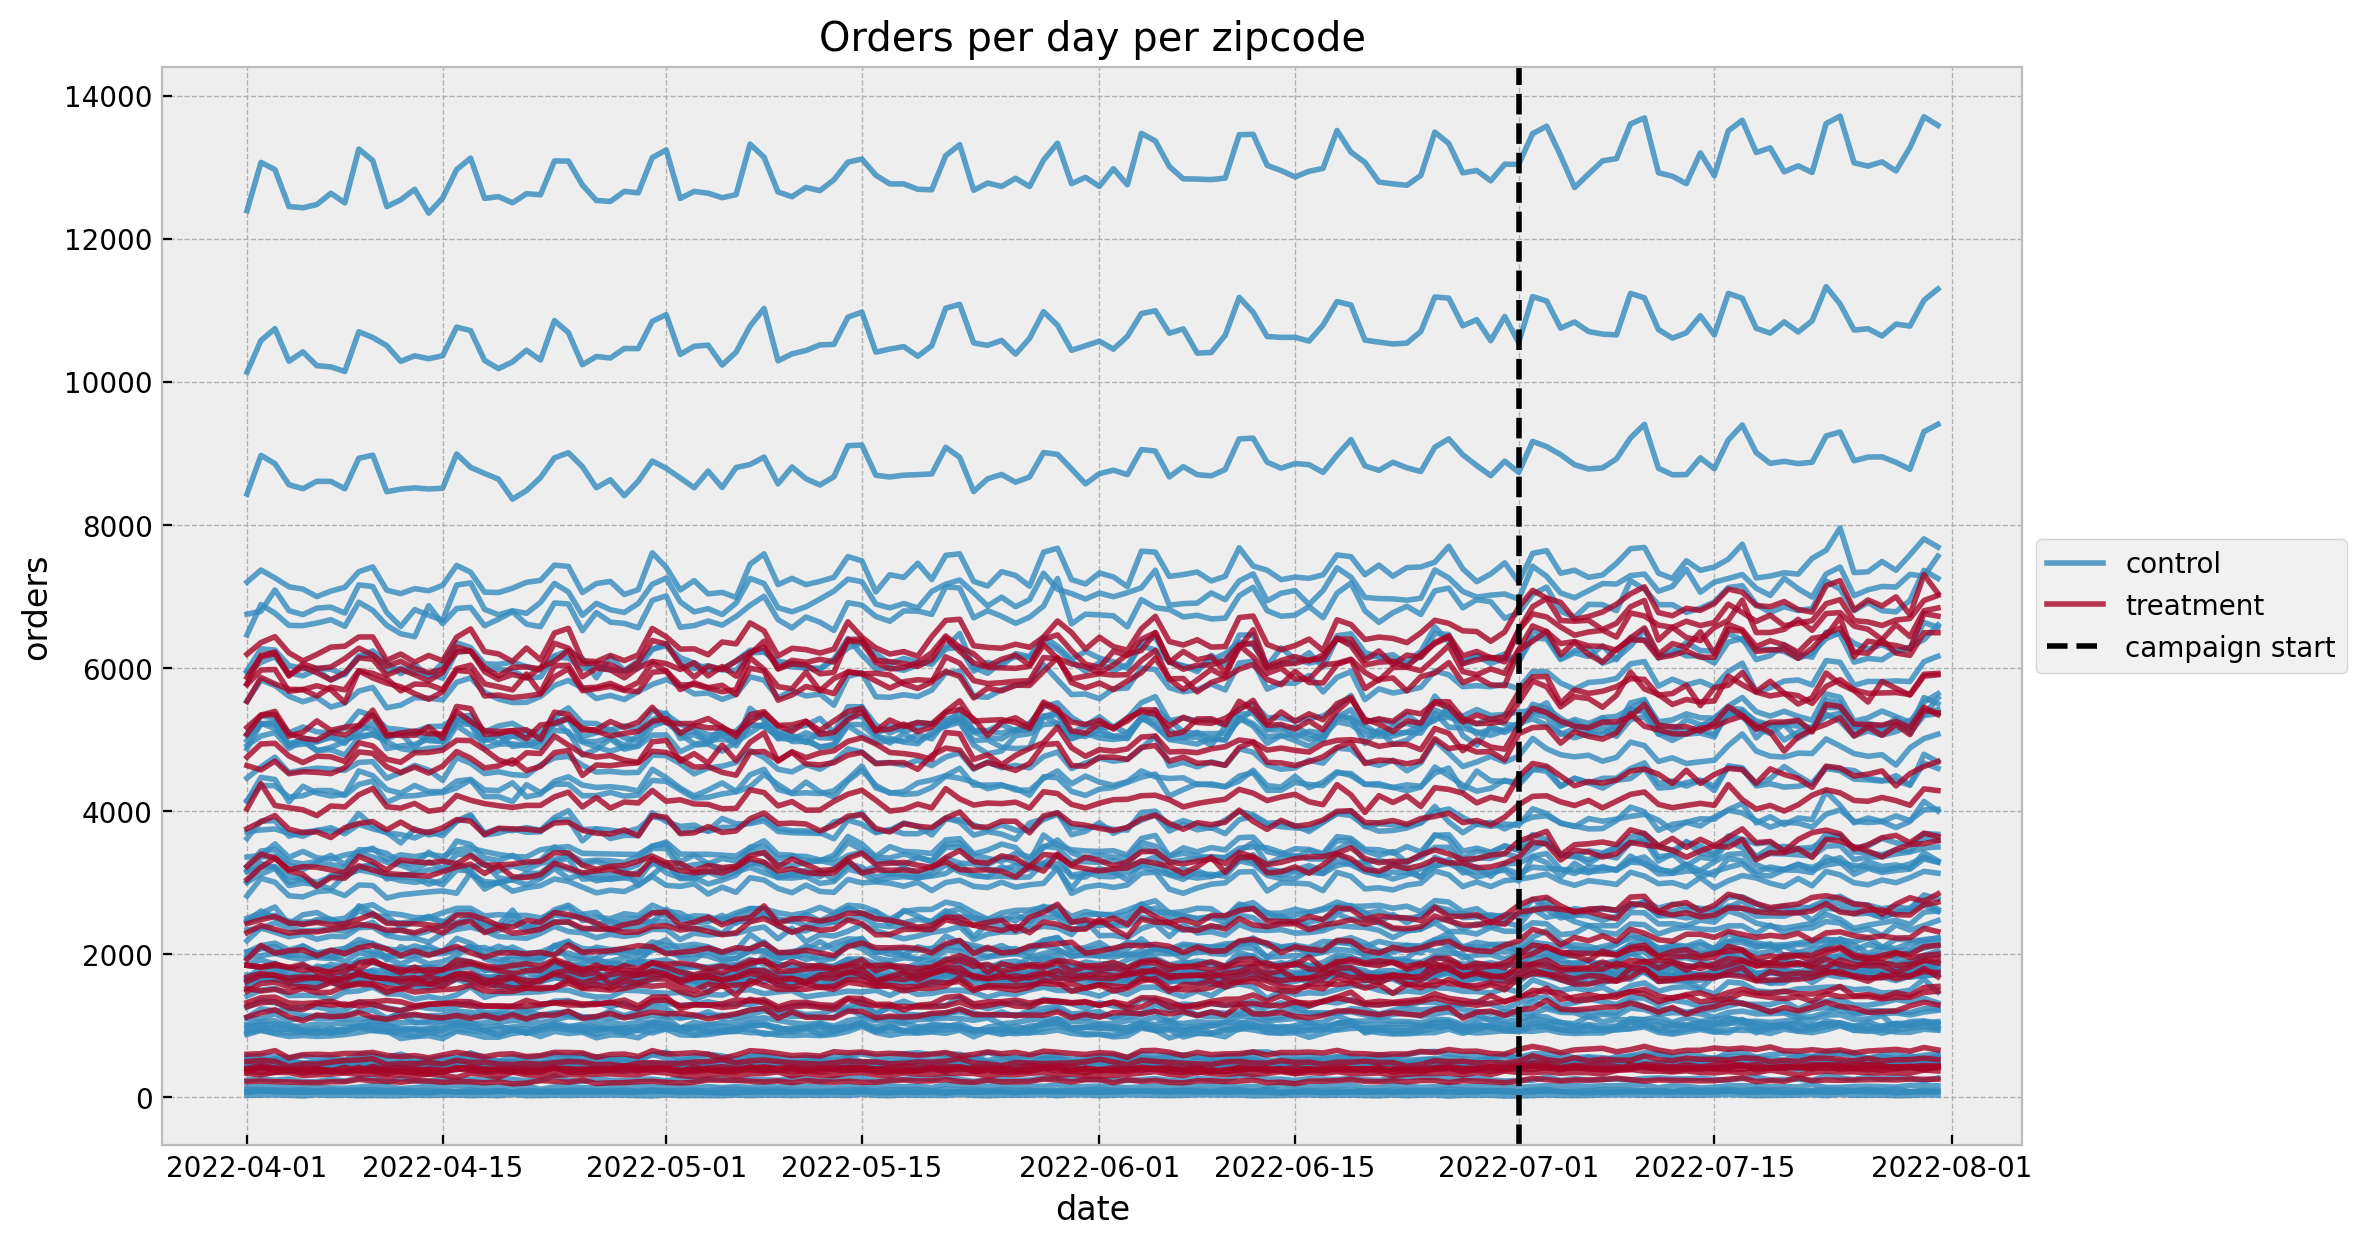

In [3]:
start_campaign = datetime(2022, 7, 1)

fig, ax = plt.subplots()

for i, variant in enumerate(["control", "treatment"]):
    for j, (_, df) in enumerate(
        data_df.query("variant == @variant").groupby("zipcode")
    ):
        label = variant if j == 0 else None
        sns.lineplot(
            x="date", y="orders", data=df, color=f"C{i}", alpha=0.8, label=label, ax=ax
        )

ax.axvline(x=start_campaign, color="black", linestyle="--", label="campaign start")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Orders per day per zipcode", xlabel="date", ylabel="orders");

We see a mild positive trend and a weekly seasonality (which is no surprise given the data generation process).

## Prepare Data

Now we prepare the data for the model, which in this case is a simple aggregation over all geos. In practice, the selection of the control geos can be done manually (given some business requirements and constraints) or semi-automatic (using some optimization algorithm as for example [A Time-Based Regression Matched Markets Approach for Designing Geo Experiments](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/b1976d70ccf7119f2193ece2d3d378d5dd0dd7be.pdf)). Note that one has to "prove" the pre-campaign linearity assumption. There are many options to do this. There are some statistical test (see the main reference for details) or one could use a time-varying coefficients model (like Uber's [Orbit-KTR](https://juanitorduz.github.io/orbit_mmm/) model or with a simple Gaussian random walk as described [here](https://juanitorduz.github.io/bikes_pymc/)).

In [4]:
agg_data_df = (
    data_df
    .groupby(["date", "is_campaign", "variant"], as_index=False)
    .agg({"orders": np.sum})
)

data_train = (
    agg_data_df.query("~ is_campaign")
    .pivot(index="date", columns="variant", values="orders")
    .reset_index()
)

data_test = (
    agg_data_df.query("is_campaign")
    .pivot(index="date", columns="variant", values="orders")
    .reset_index()
)

Next, we do a pre and post campaign split of the data.

In [5]:
date_train = data_train["date"].to_numpy()
y_control_train = data_train["control"].to_numpy()
y_treatment_train = data_train["treatment"].to_numpy()

date_test = data_test["date"].to_numpy()
y_control_test = data_test["control"].to_numpy()
y_treatment_test = data_test["treatment"].to_numpy()

n_train = data_train.shape[0]
n_test = data_test.shape[0]
n = n_train + n_test
idx_train = range(n_train)
idx_test = range(n_train, n)

In order to stablish suitable priors we scale the data (as suggested by [Richard McElreath](https://xcelab.net/rm/) in [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/)):

In [6]:
scaler_control = StandardScaler()
scaler_treatment = StandardScaler()

scaler_control.fit(X=y_control_train[..., None])
scaler_treatment.fit(X=y_treatment_train[..., None])

y_control_train_scaled = scaler_control.transform(
    X=y_control_train[..., None]
).flatten()
y_treatment_train_scaled = scaler_treatment.transform(
    X=y_treatment_train[..., None]
).flatten()

y_control_test_scaled = scaler_control.transform(X=y_control_test[..., None]).flatten()
y_treatment_test_scaled = scaler_treatment.transform(
    X=y_treatment_test[..., None]
).flatten()

Let's take a look at the scaled data:

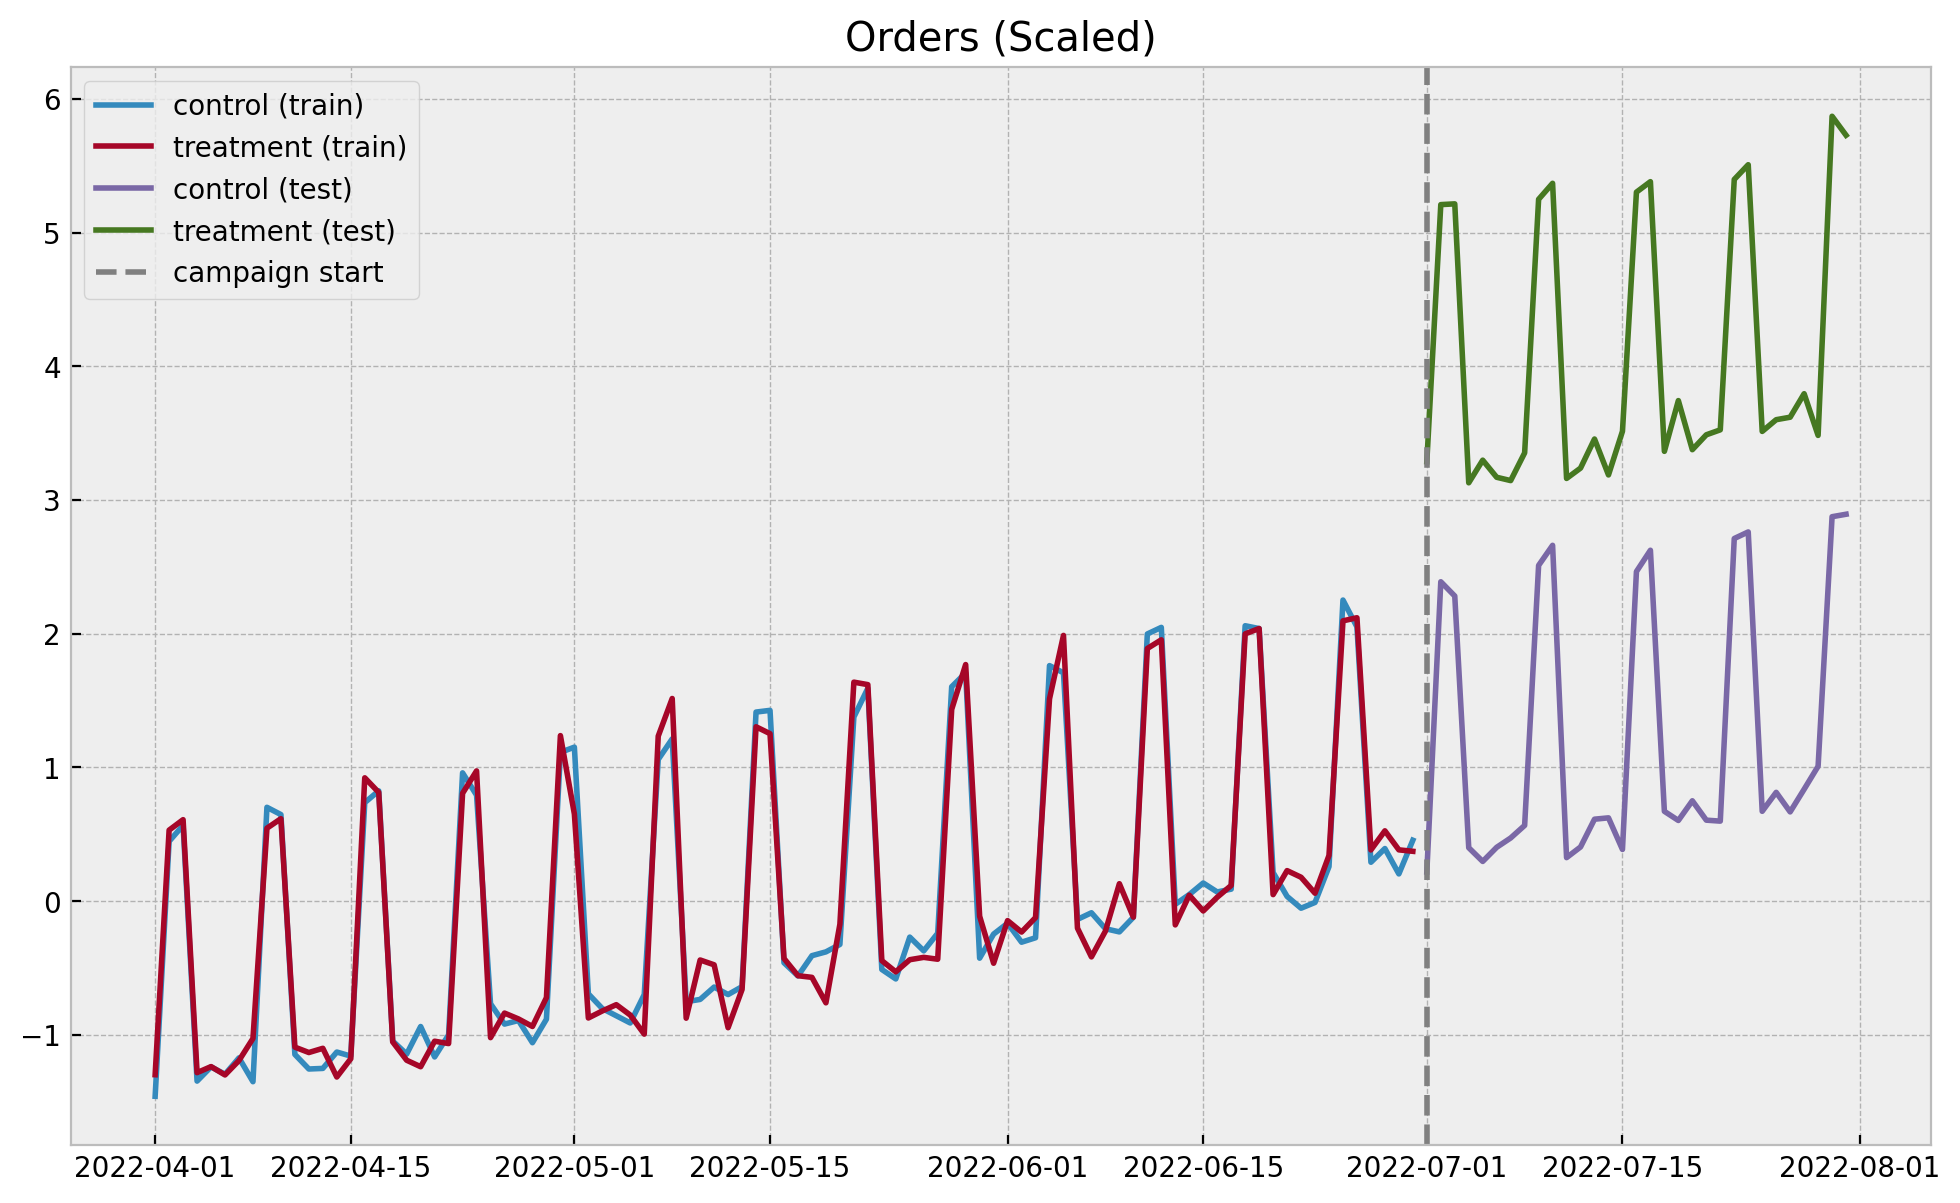

In [7]:
fig, ax = plt.subplots()
sns.lineplot(
    x=date_train, y=y_control_train_scaled, color="C0", label="control (train)", ax=ax
)
sns.lineplot(
    x=date_train,
    y=y_treatment_train_scaled,
    color="C1",
    label="treatment (train)",
    ax=ax,
)
sns.lineplot(
    x=date_test, y=y_control_test_scaled, color="C2", label="control (test)", ax=ax
)
sns.lineplot(
    x=date_test,
    y=y_treatment_test_scaled,
    color="C3",
    label="treatment (test)",
    ax=ax,
)
ax.axvline(x=start_campaign, color="gray", linestyle="--", label="campaign start")
ax.legend(loc="upper left")
ax.set(title="Orders (Scaled)");

In this simulated example the pre-campaign linearity assumption seems to hold. 

## Define Model

Now we define the linear regression model. One of the benefits of the Bayesian approach is the ability to encode domain knowledge. In this example we impose the regression coefficient $\beta$ to be positive, which is reasonable given the pre-campaign data. In addition, we use a Student-t likelihood to account for potential outliers in the data.

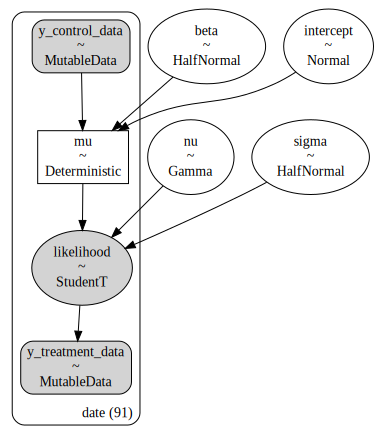

In [8]:
with pm.Model() as model:
    # --- Data Containers ---
    model.add_coord(name="date", values=date_train, mutable=True)
    y_control_data = pm.MutableData(
        name="y_control_data", value=y_control_train_scaled, dims="date"
    )
    y_treatment_data = pm.MutableData(
        name="y_treatment_data", value=y_treatment_train_scaled, dims="date"
    )
    # --- Priors ---
    intercept = pm.Normal(name="intercept", mu=0, sigma=1)
    beta = pm.HalfNormal(name="beta", sigma=2)
    sigma = pm.HalfNormal(name="sigma", sigma=2)
    nu = pm.Gamma(name="nu", alpha=20, beta=2)
    # --- Model Parametrization ---
    mu = pm.Deterministic(name="mu", var=intercept + beta * y_control_data, dims="date")
    # --- Likelihood ---
    likelihood = pm.StudentT(
        "likelihood", mu=mu, nu=nu, sigma=sigma, observed=y_treatment_data, dims="date"
    )

pm.model_to_graphviz(model=model)

## Prior Predictive Check

Before fitting the model, we run some prior predictive checks. This is a good way to check that the model is well defined and that the priors are reasonable.

In [9]:
with model:
    prior_predictive: az.InferenceData = pm.sample_prior_predictive(samples=1000)

Sampling: [beta, intercept, likelihood, nu, sigma]
INFO:pymc:Sampling: [beta, intercept, likelihood, nu, sigma]


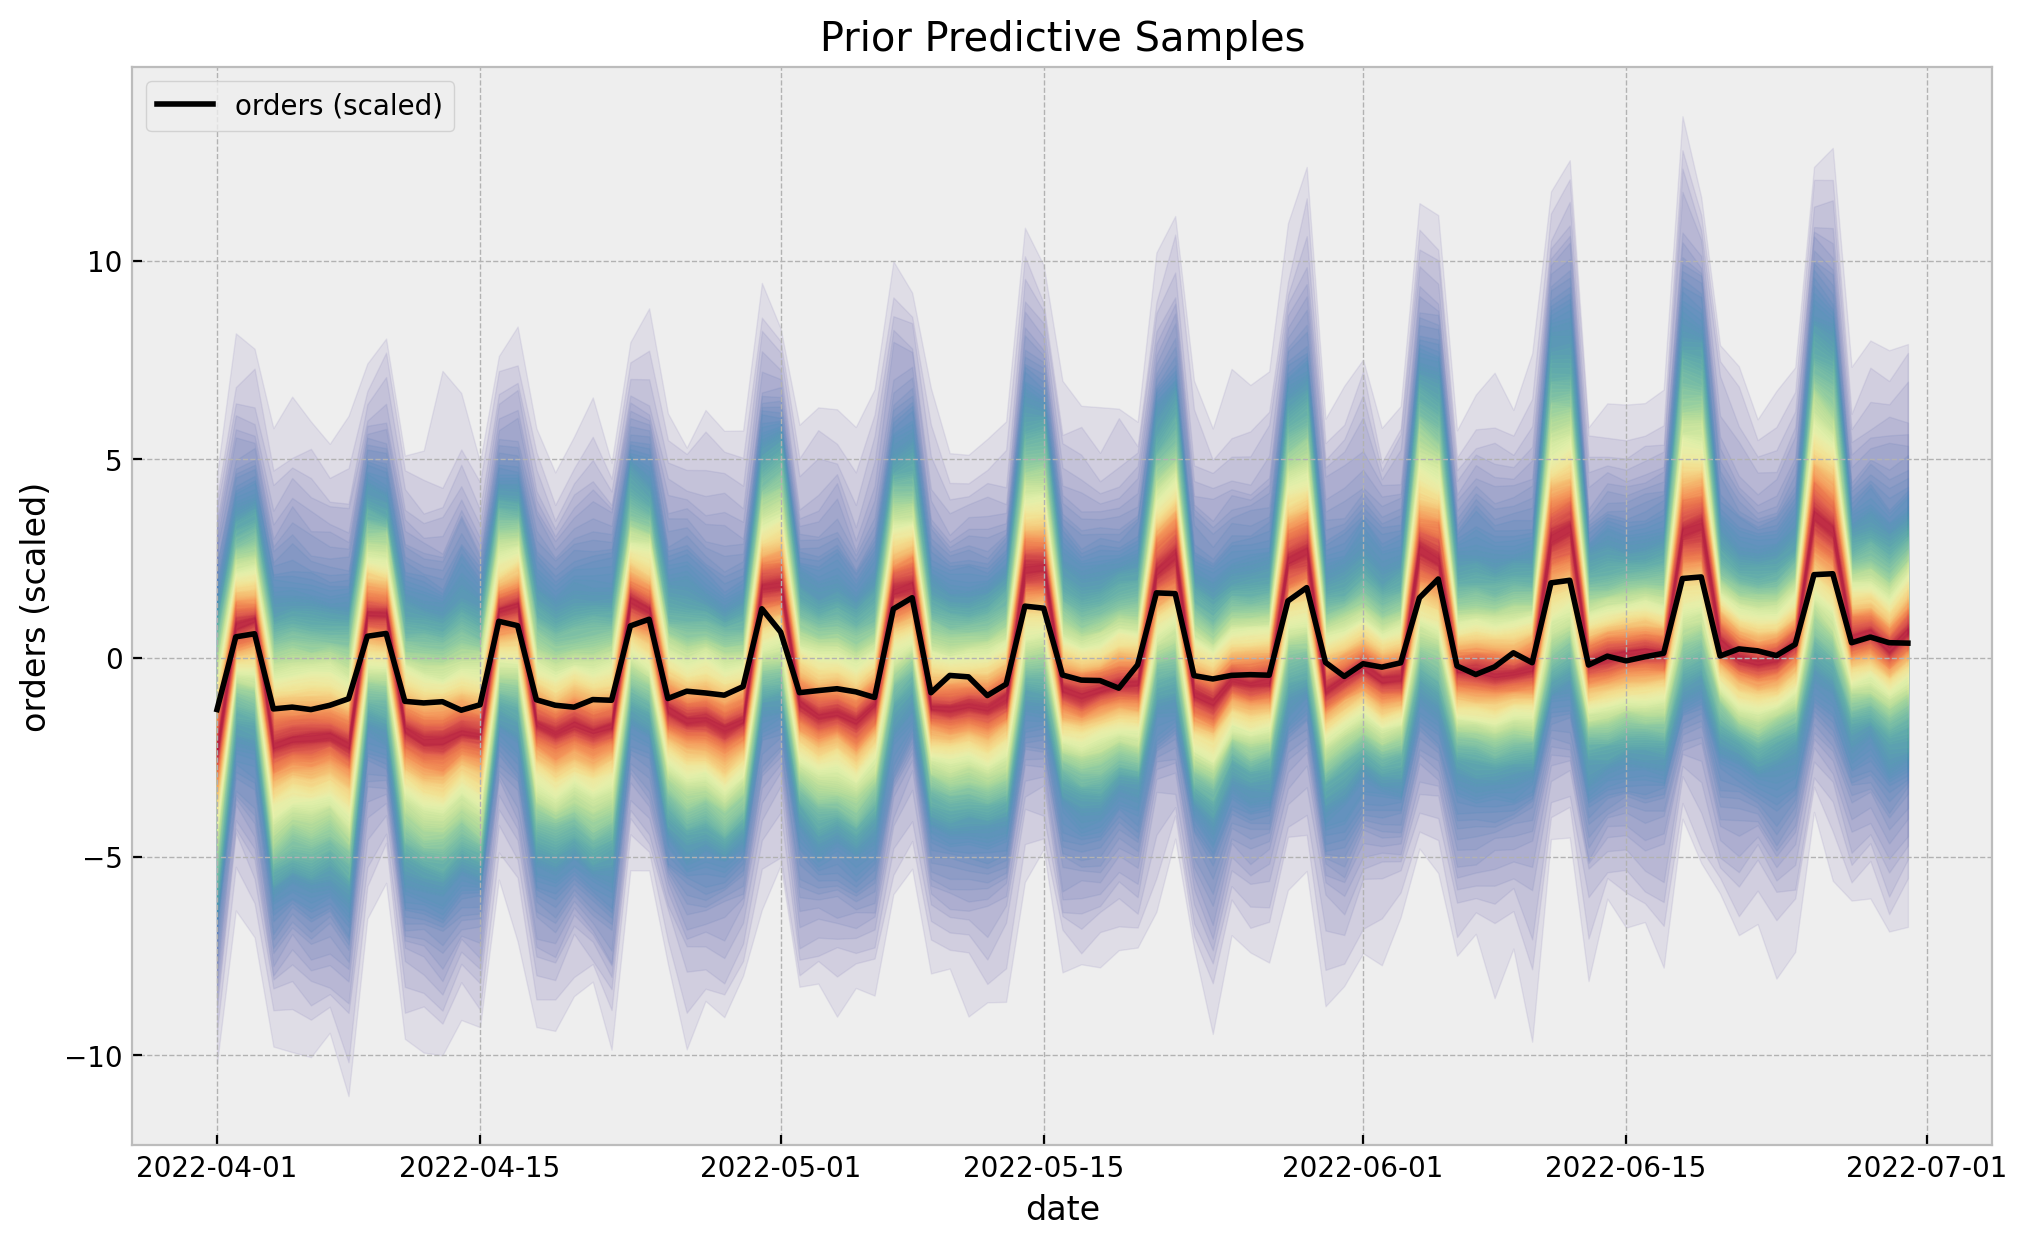

In [10]:
palette = "Spectral_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


fig, ax = plt.subplots()

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(prior_predictive.prior_predictive["likelihood"], p, axis=1)
    lower = np.percentile(
        prior_predictive.prior_predictive["likelihood"], 100 - p, axis=1
    )
    color_val = colors[i]
    ax.fill_between(
        x=date_train,
        y1=upper.flatten(),
        y2=lower.flatten(),
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=date_train,
    y=y_treatment_train_scaled,
    label="orders (scaled)",
    color="black",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(title="Prior Predictive Samples", xlabel="date", ylabel="orders (scaled)");

The prior predictive check looks good!

## Fit Model

In [11]:
with model:
    idata: az.InferenceData = pm.sampling_jax.sample_numpyro_nuts(draws=5000, chains=4)
    posterior_predictive: az.InferenceData = pm.sample_posterior_predictive(trace=idata)

Compiling...
Compilation time =  0:00:02.615535
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:00:05.228661
Transforming variables...
Transformation time =  0:00:00.179315
Computing Log Likelihood...


Sampling: [likelihood]
INFO:pymc:Sampling: [likelihood]


Log Likelihood time =  0:00:01.061900


## Model Diagnostics

We can now look into some model diagnostics.

In [12]:
var_names: list[str] = ["intercept","beta", "sigma", "nu"]

az.summary(data=idata, var_names=var_names)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept   0.003  0.018  -0.032    0.035      0.000    0.000   20282.0   
beta        0.985  0.018   0.952    1.018      0.000    0.000   21158.0   
sigma       0.157  0.014   0.132    0.183      0.000    0.000   20300.0   
nu         10.363  2.211   6.493   14.640      0.015    0.011   20363.0   

           ess_tail  r_hat  
intercept   13794.0    1.0  
beta        15286.0    1.0  
sigma       15498.0    1.0  
nu          14352.0    1.0

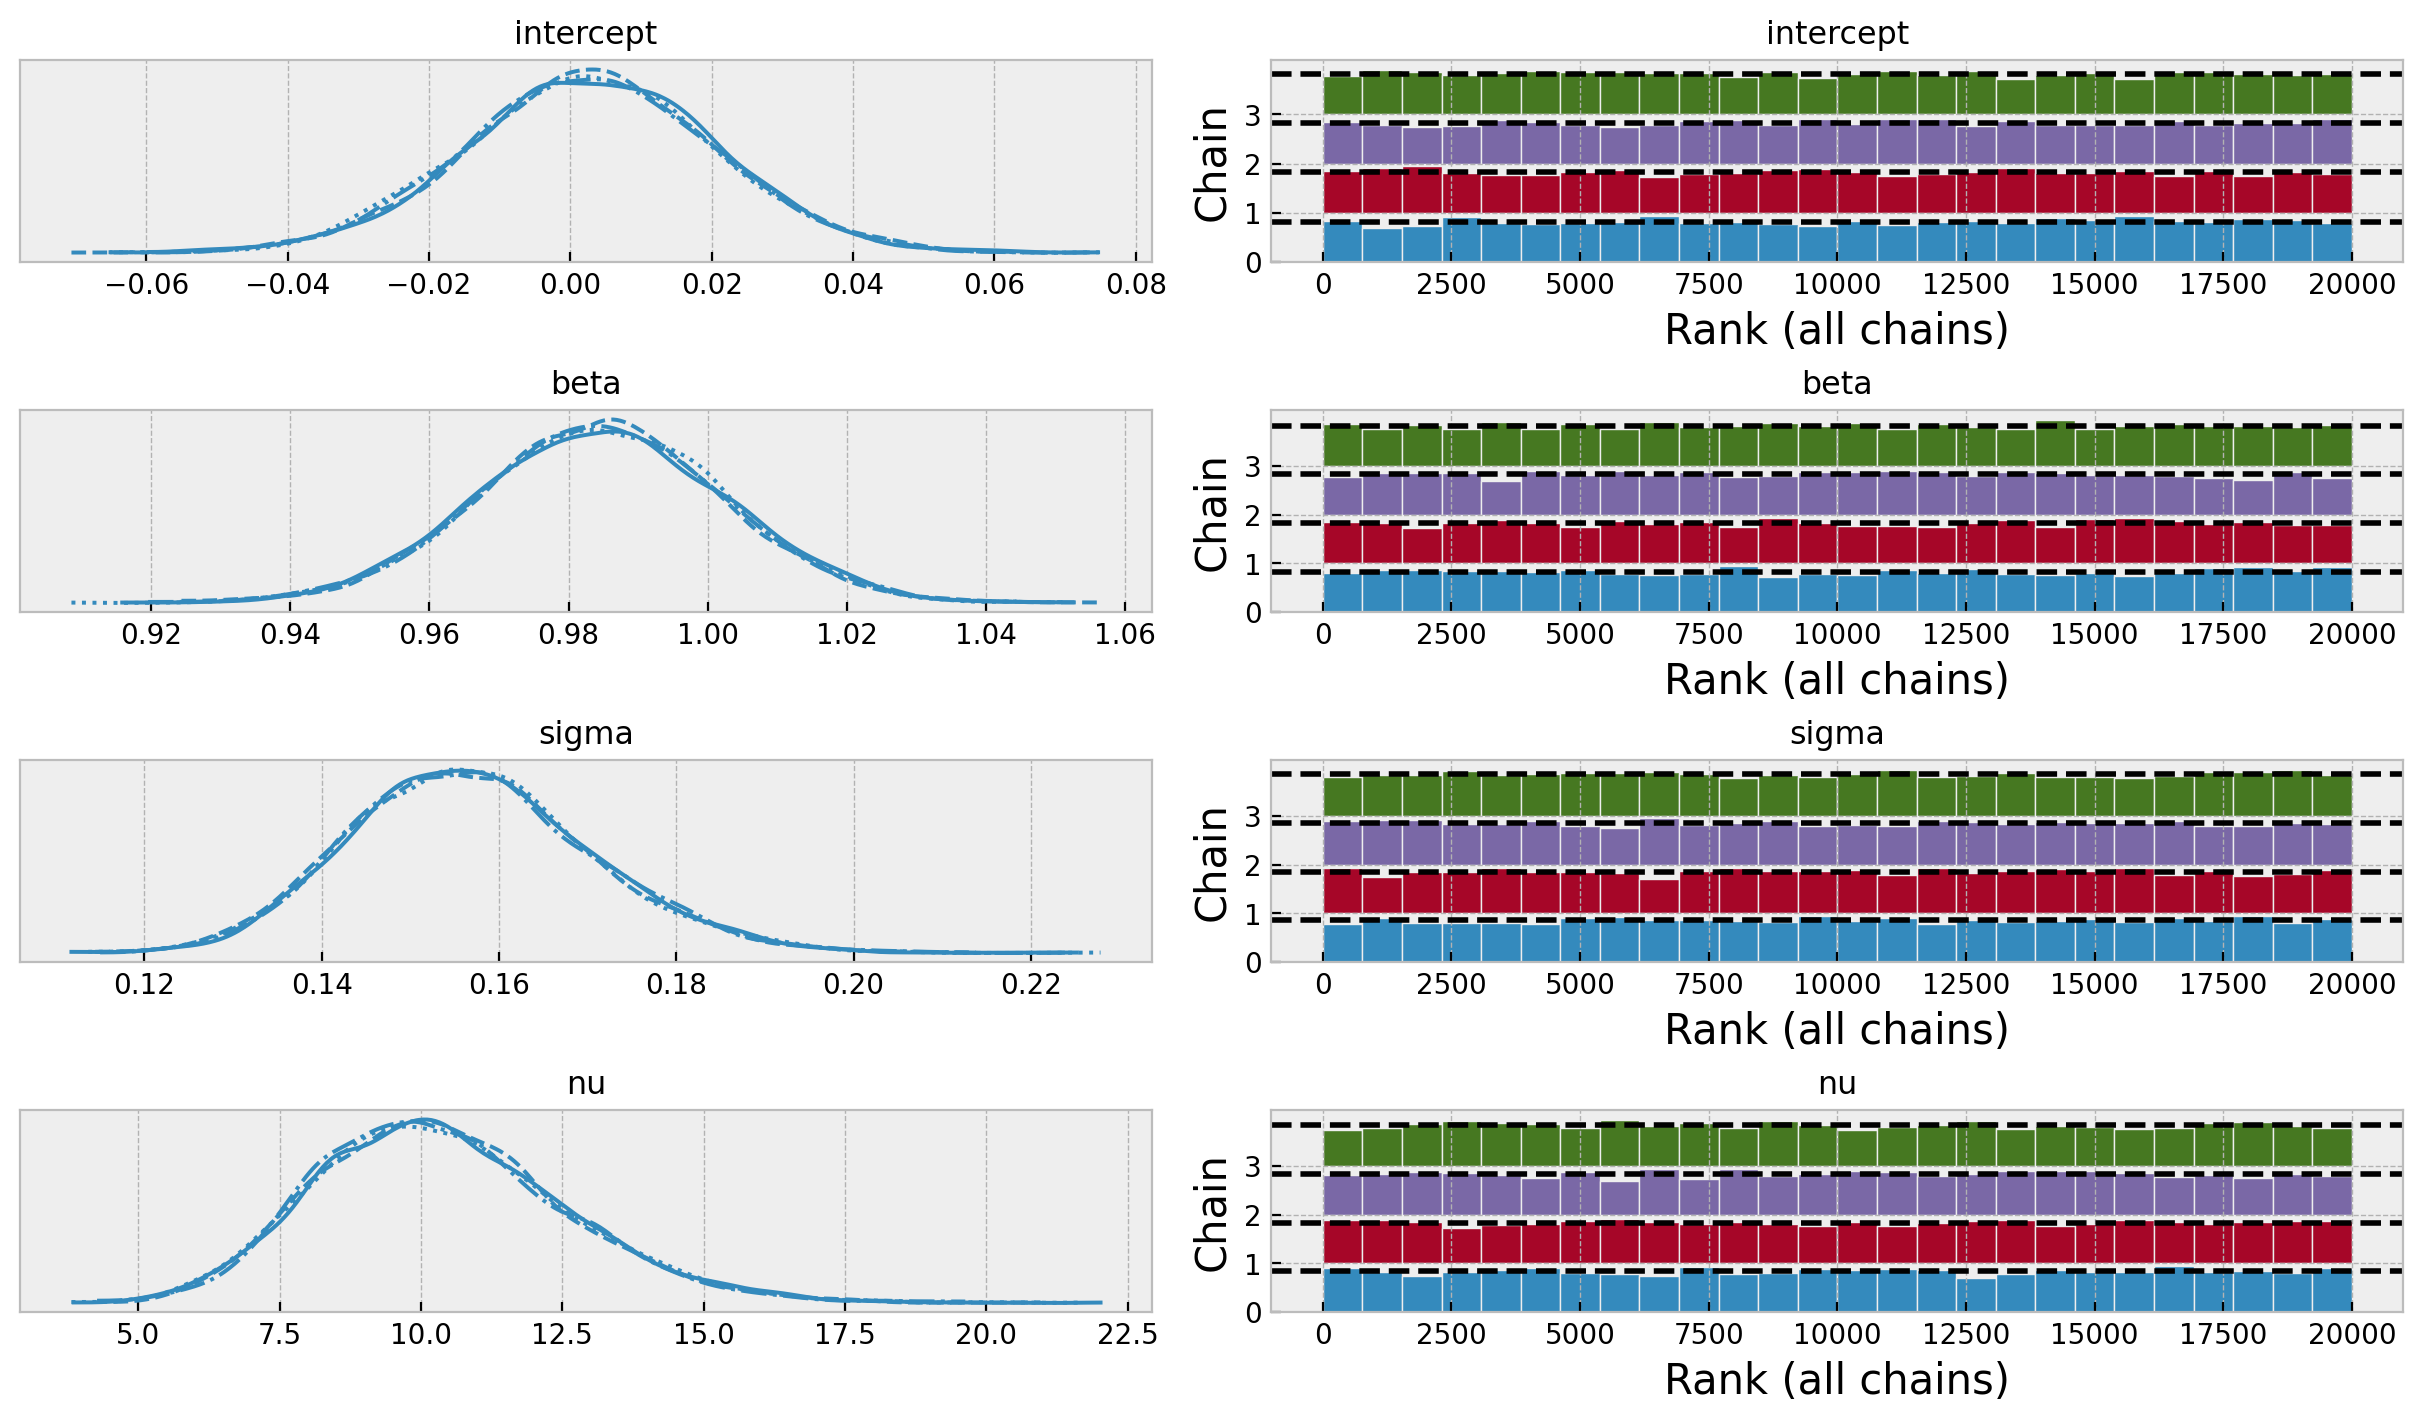

In [13]:
axes = az.plot_trace(
    data=idata,
    var_names=var_names,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)


The model posterior distributions look good. In particular, note that the intercept and the regression coefficient are centered around zero and one respectively. This is to be expected given the scaling of the data.

## Posterior Predictive (Train)

We now look at the posterior predictive distribution for the training (pre-campaign) data

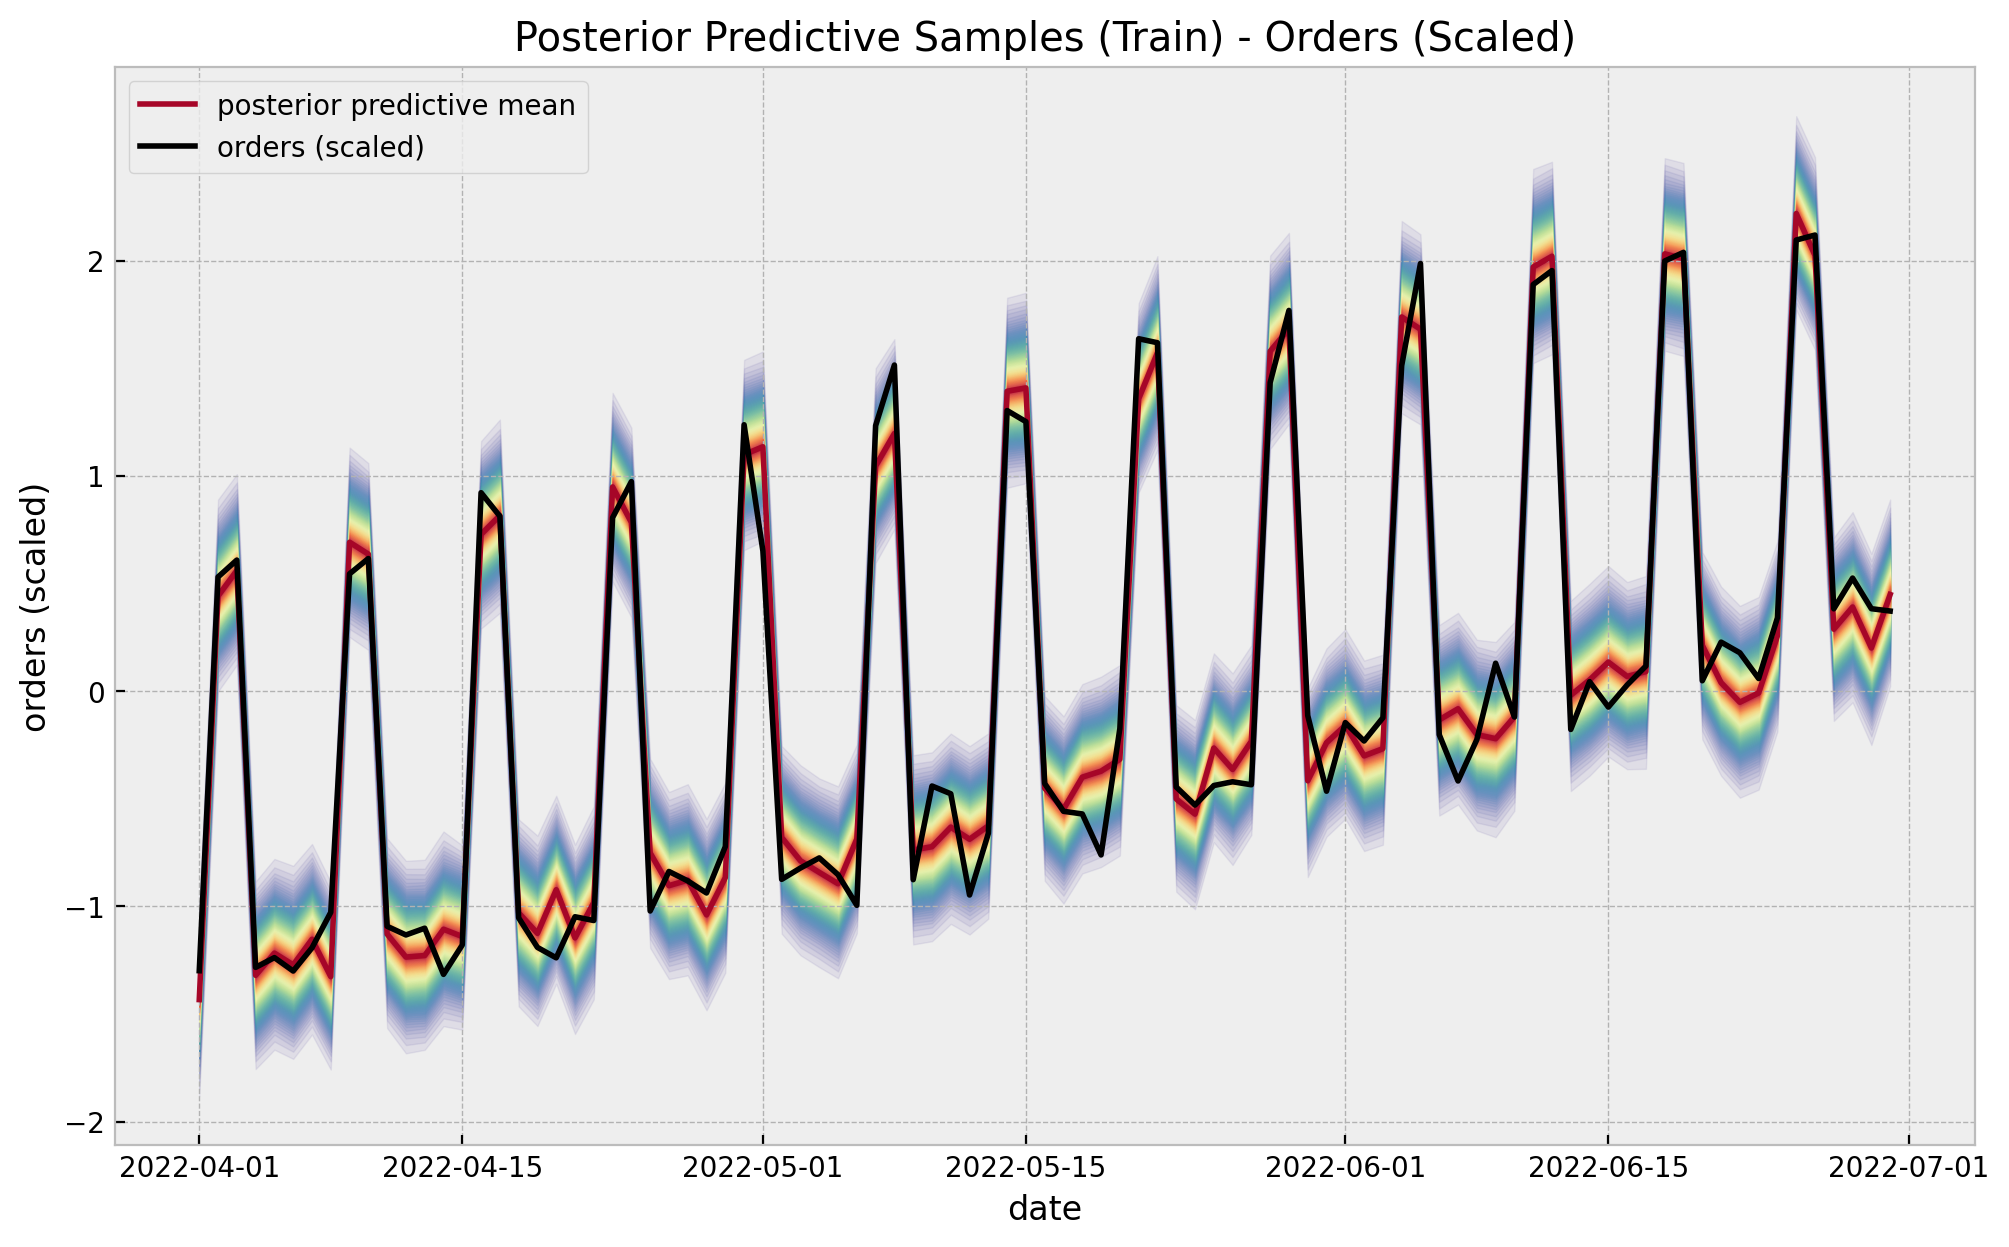

In [14]:
posterior_predictive_likelihood_train: DataArray = az.extract(
    data=posterior_predictive, group="posterior_predictive", var_names=["likelihood"]
)

fig, ax = plt.subplots()

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood_train, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood_train, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=date_train,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=date_train,
    y=posterior_predictive_likelihood_train.mean(axis=1),
    color="C1",
    label="posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=date_train,
    y=y_treatment_train_scaled,
    color="black",
    label="orders (scaled)",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(
    title="Posterior Predictive Samples (Train) - Orders (Scaled)",
    xlabel="date",
    ylabel="orders (scaled)",
);

We can visualize the predictions in a different way to clearly see linear relationship.

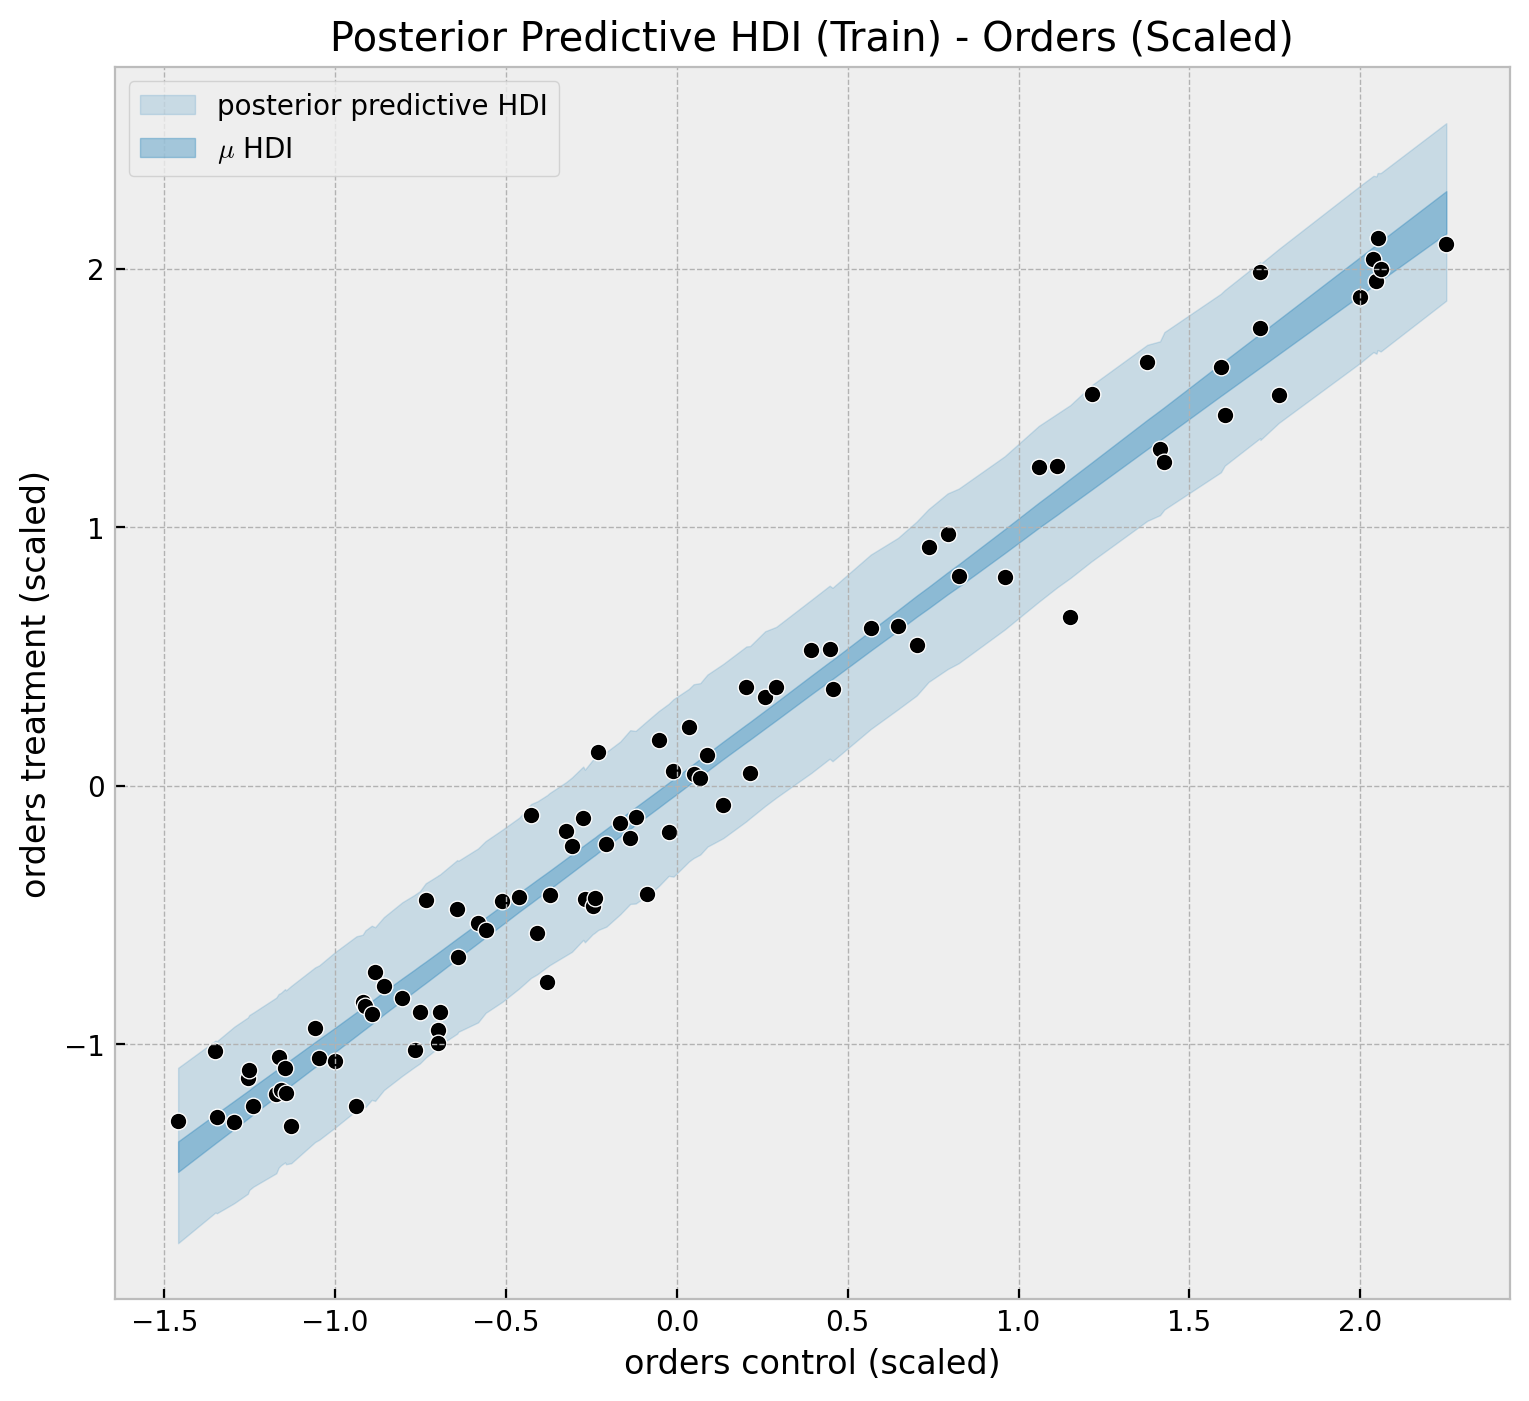

In [15]:
hdi_train_likelihood: DataArray = az.hdi(
    ary=posterior_predictive, group="posterior_predictive"
)["likelihood"]

hdi_train_mu: DataArray = az.hdi(ary=idata, group="posterior")["mu"]

idx_train_sorted = np.argsort(a=y_control_train_scaled)

fig, ax = plt.subplots(figsize=(9, 8))
ax.fill_between(
    x=y_control_train_scaled[idx_train_sorted],
    y1=hdi_train_likelihood[:, 0][idx_train_sorted],
    y2=hdi_train_likelihood[:, 1][idx_train_sorted],
    color="C0",
    alpha=0.2,
    label="posterior predictive HDI",
)
ax.fill_between(
    x=y_control_train_scaled[idx_train_sorted],
    y1=hdi_train_mu[:, 0][idx_train_sorted],
    y2=hdi_train_mu[:, 1][idx_train_sorted],
    color="C0",
    alpha=0.4,
    label=r"$\mu$ HDI",
)
sns.scatterplot(
    x=y_control_train_scaled[idx_train_sorted],
    y=y_treatment_train_scaled[idx_train_sorted],
    color="black",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(
    title="Posterior Predictive HDI (Train) - Orders (Scaled)",
    xlabel="orders control (scaled)",
    ylabel="orders treatment (scaled)",
);

We can compute the errors distribution of the model:

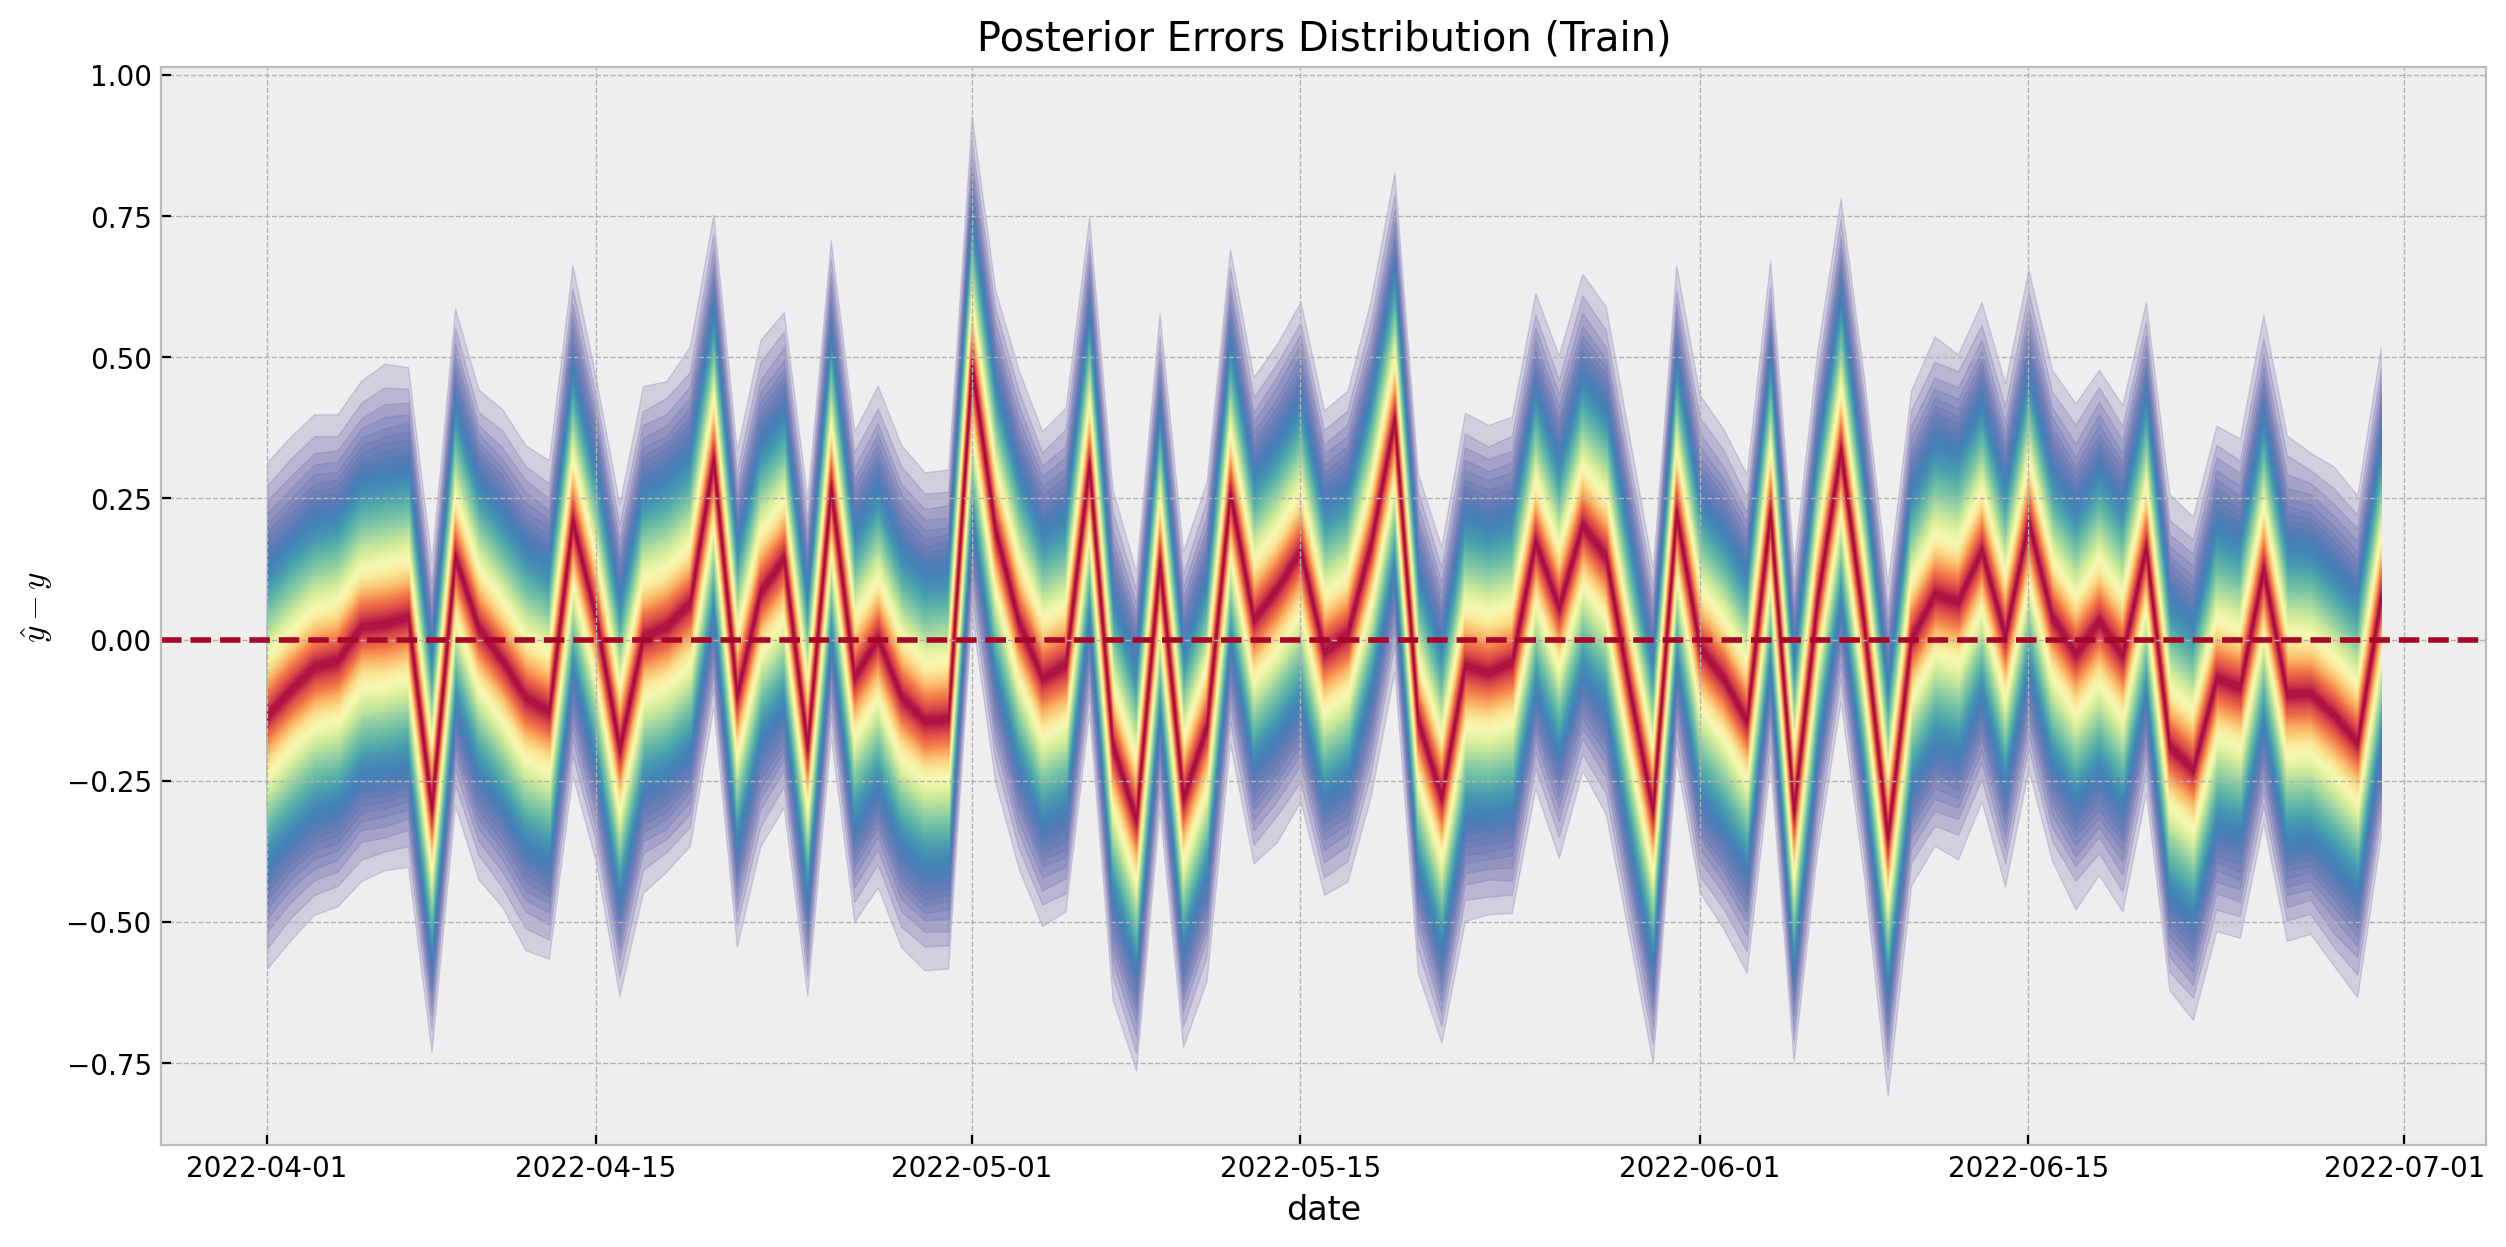

In [16]:
errors_train: DataArray = (
    posterior_predictive_likelihood_train - y_treatment_train_scaled[..., None]
)

fig, ax = plt.subplots(figsize=(15, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(a=errors_train, q=p, axis=1)
    lower = np.percentile(a=errors_train, q=100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(x=date_train, y1=upper, y2=lower, color=cmap(color_val), alpha=0.2)

ax.axhline(y=0, color="C1", linestyle="--")
ax.set(
    title="Posterior Errors Distribution (Train)",
    xlabel="date",
    ylabel=r"$\hat{y} - y$",
);

We do not see any patterns or weird behavior in the errors distribution.

## Uncertainty Quantification

In [30]:
def generate_folds_indices(n_train: int, n_test: int) -> npt.NDArray[np.int_]:
    """Generate cyclic folds indices."""
    return np.array(
        [np.arange(start=i, stop=i + n_test) % n_train for i in range(n_train)]
    )


folds_indices: npt.NDArray[np.int_] = generate_folds_indices(n_train=n_train, n_test=n_test)

folds_indices

array([[ 0,  1,  2, ..., 28, 29, 30],
       [ 1,  2,  3, ..., 29, 30, 31],
       [ 2,  3,  4, ..., 30, 31, 32],
       ...,
       [88, 89, 90, ..., 25, 26, 27],
       [89, 90,  0, ..., 26, 27, 28],
       [90,  0,  1, ..., 27, 28, 29]])

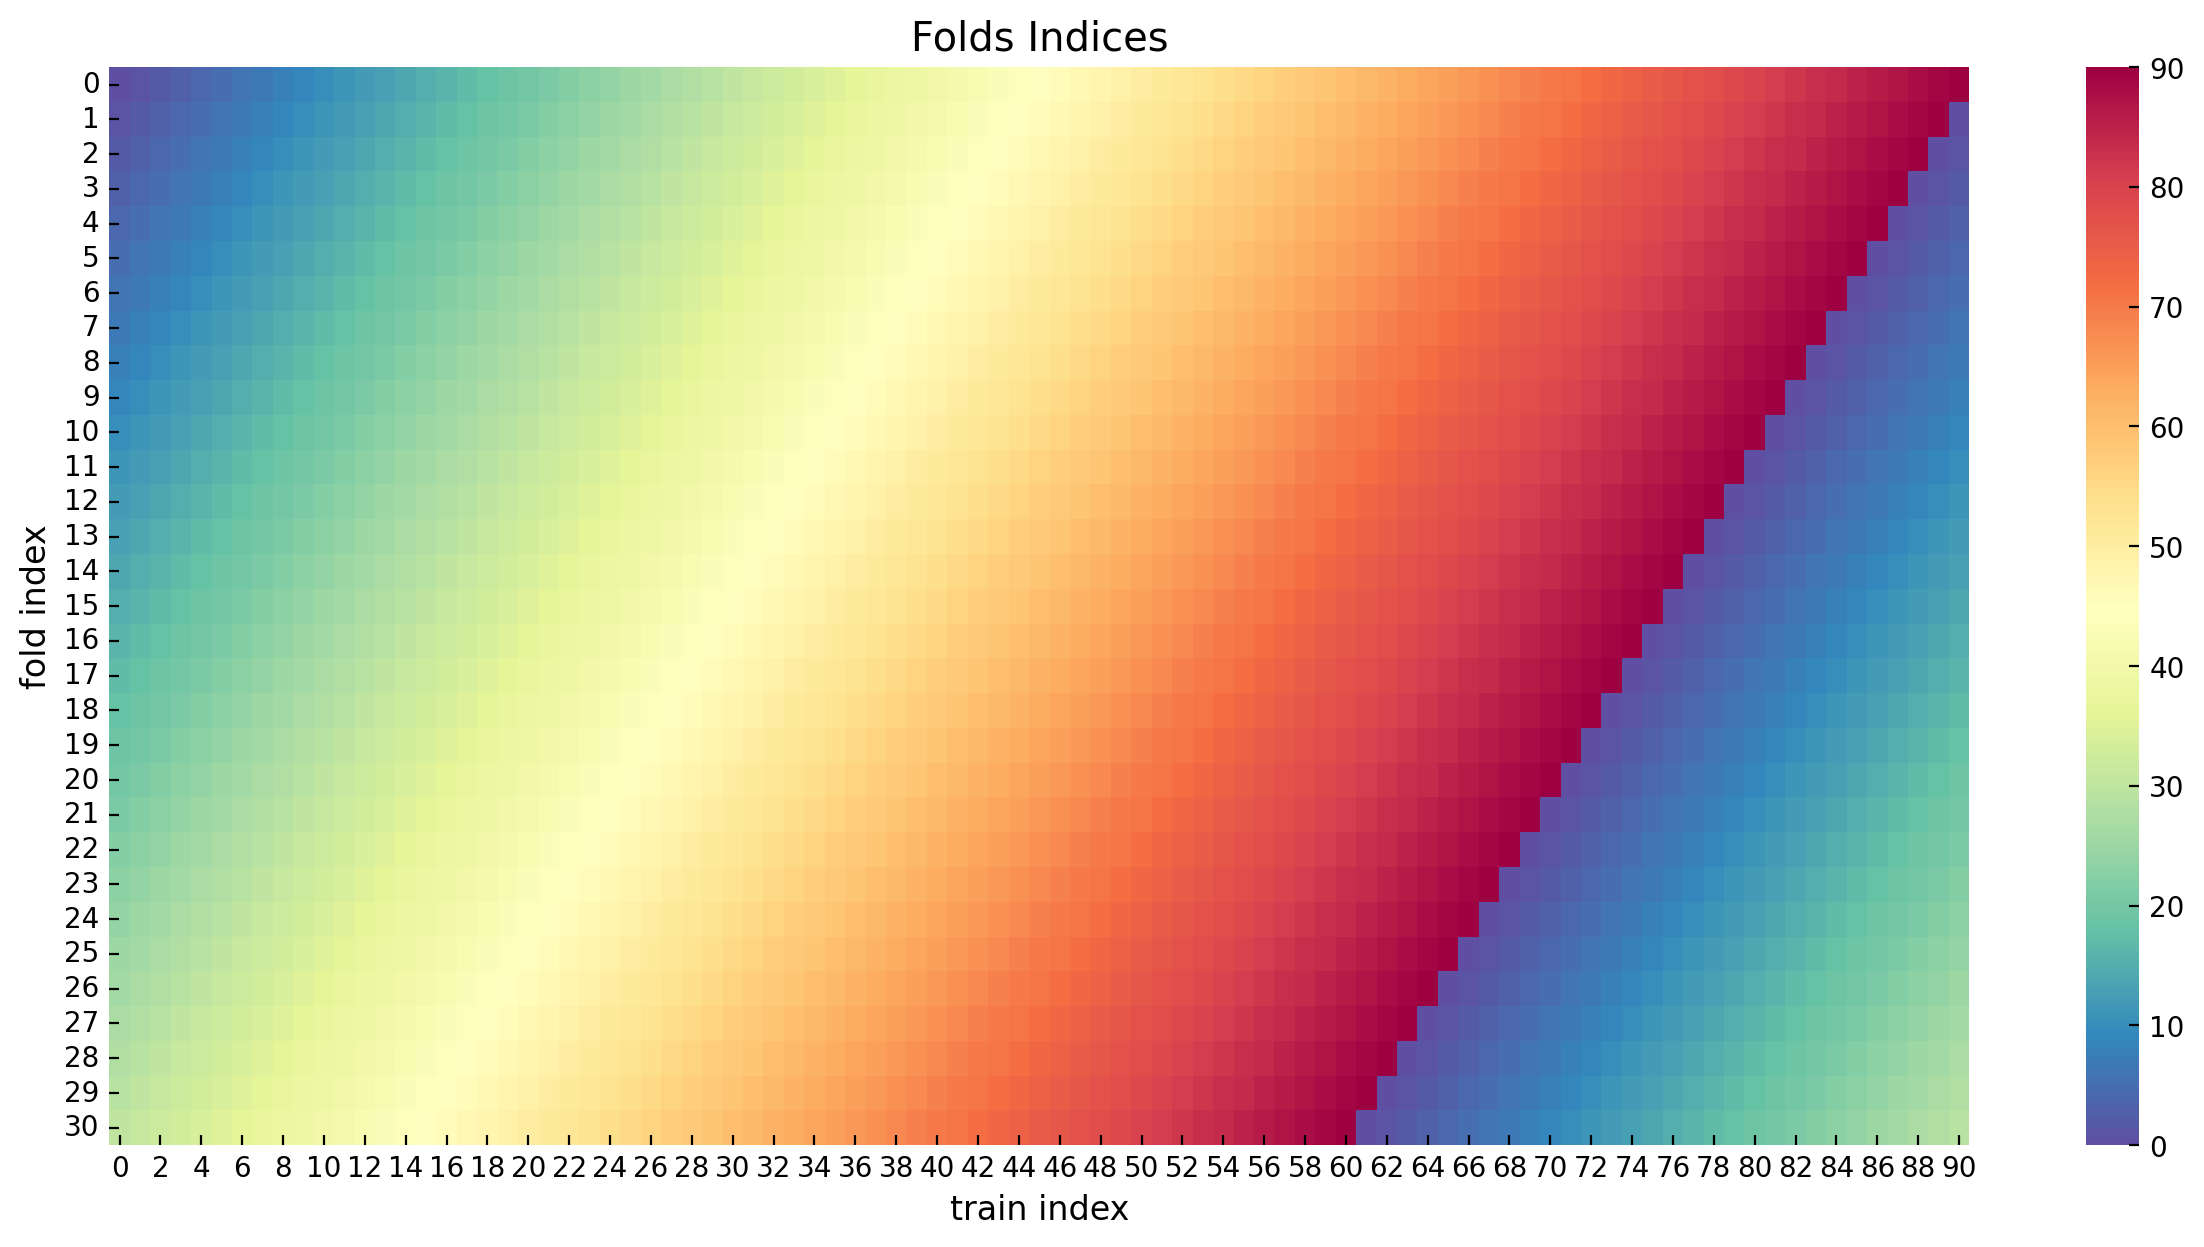

In [55]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(data=folds_indices.T, cmap="Spectral_r", ax=ax)
ax.set(title="Folds Indices", xlabel="train index", ylabel="fold index");

In [18]:
folds_errors_list: list[npt.NDArray[np.float_]] = []
# generate prediction for each fold and compute the errors (original scale).
for i in tqdm(range(n_train)):
    idx = folds_indices[i, :]
    likelihood_fold = posterior_predictive_likelihood_train[idx, :]
    y_control_fold_scaled_pred = scaler_control.inverse_transform(X=likelihood_fold)
    y_control_fold_scaled = y_control_train[idx]
    error_control_fold = y_control_fold_scaled[..., None] - y_control_fold_scaled_pred
    folds_errors_list.append(error_control_fold)

folds_errors = np.array(folds_errors_list)

# compute the HDI and the median across folds.
folds_hdi = az.hdi(ary=np.moveaxis(a=folds_errors, source=0, destination=2))
folds_hdi_median = np.median(a=folds_hdi, axis=0)


  0%|          | 0/91 [00:00<?, ?it/s]

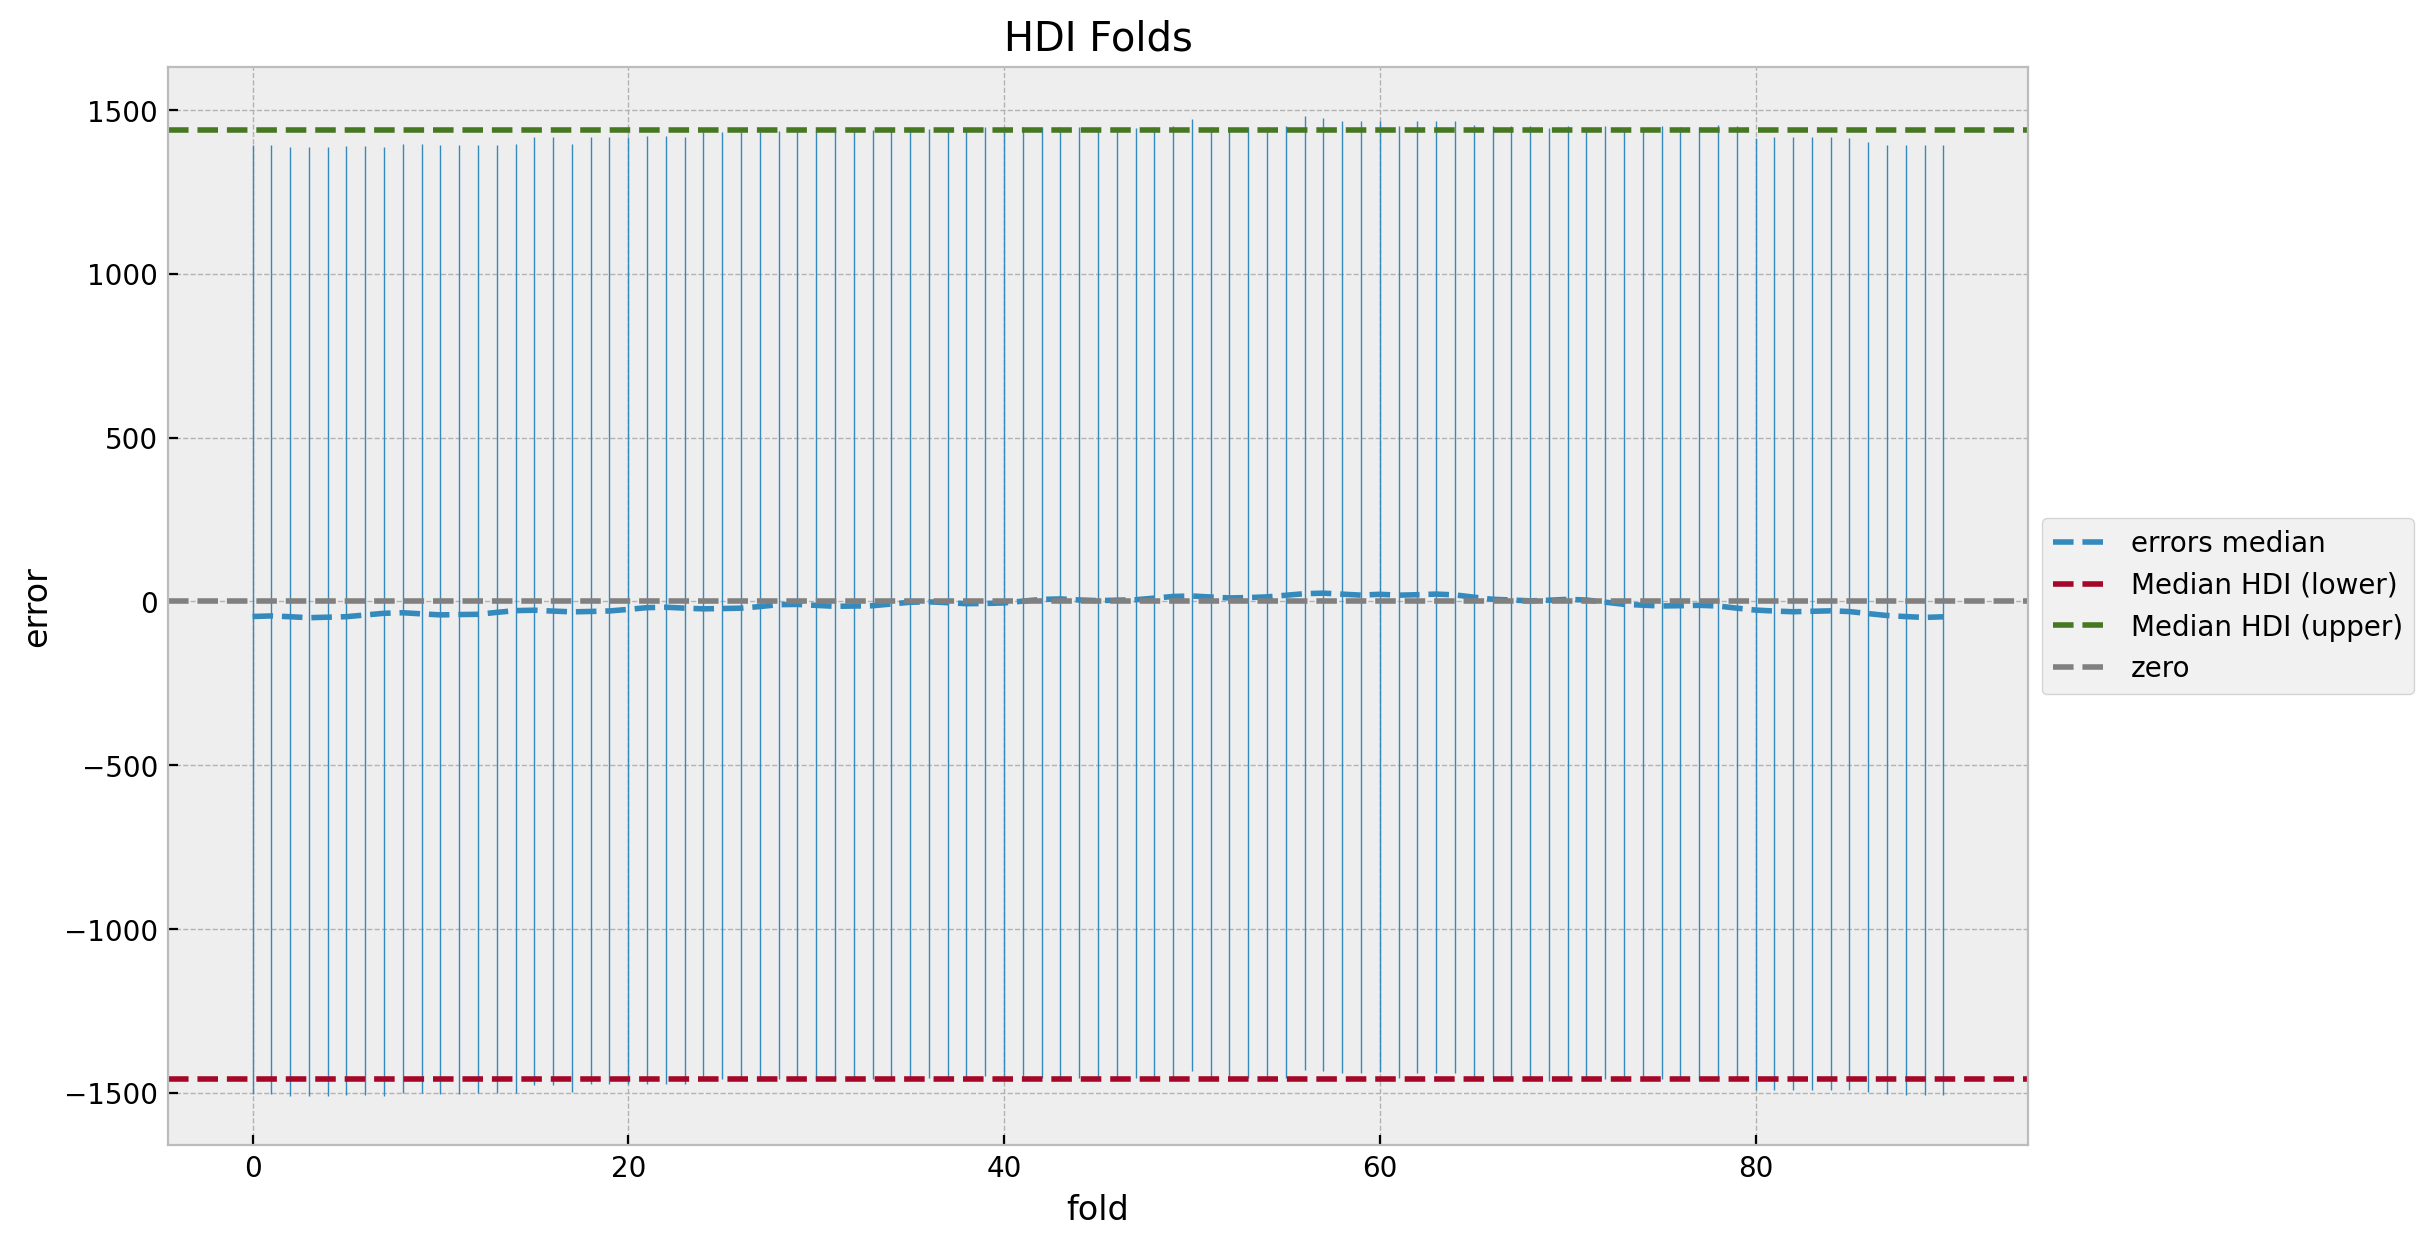

In [19]:
fig, ax = plt.subplots()

for i in range(n_train):
    ax.vlines(
        x=i,
        ymin=folds_hdi[i, 0],
        ymax=folds_hdi[i, 1],
        linestyle="solid",
        linewidth=0.5,
    )
ax.plot(
    np.median(folds_errors.reshape(n_train, -1), axis=1),
    color="C0",
    linestyle="dashed",
    label="errors median",
)
ax.axhline(
    y=folds_hdi_median[0], color="C1", linestyle="dashed", label="Median HDI (lower)"
)
ax.axhline(
    y=folds_hdi_median[1], color="C3", linestyle="dashed", label="Median HDI (upper)"
)
ax.axhline(y=0.0, color="gray", linestyle="--", label="zero")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="HDI Folds", xlabel="fold", ylabel="error");

In [20]:
folds_errors_cumsum = folds_errors.cumsum(axis=1)
folds_cumsum_hdi = az.hdi(ary=np.moveaxis(a=folds_errors_cumsum, source=0, destination=2))
folds_cumsum_hdi_median = np.median(a=folds_cumsum_hdi, axis=0)

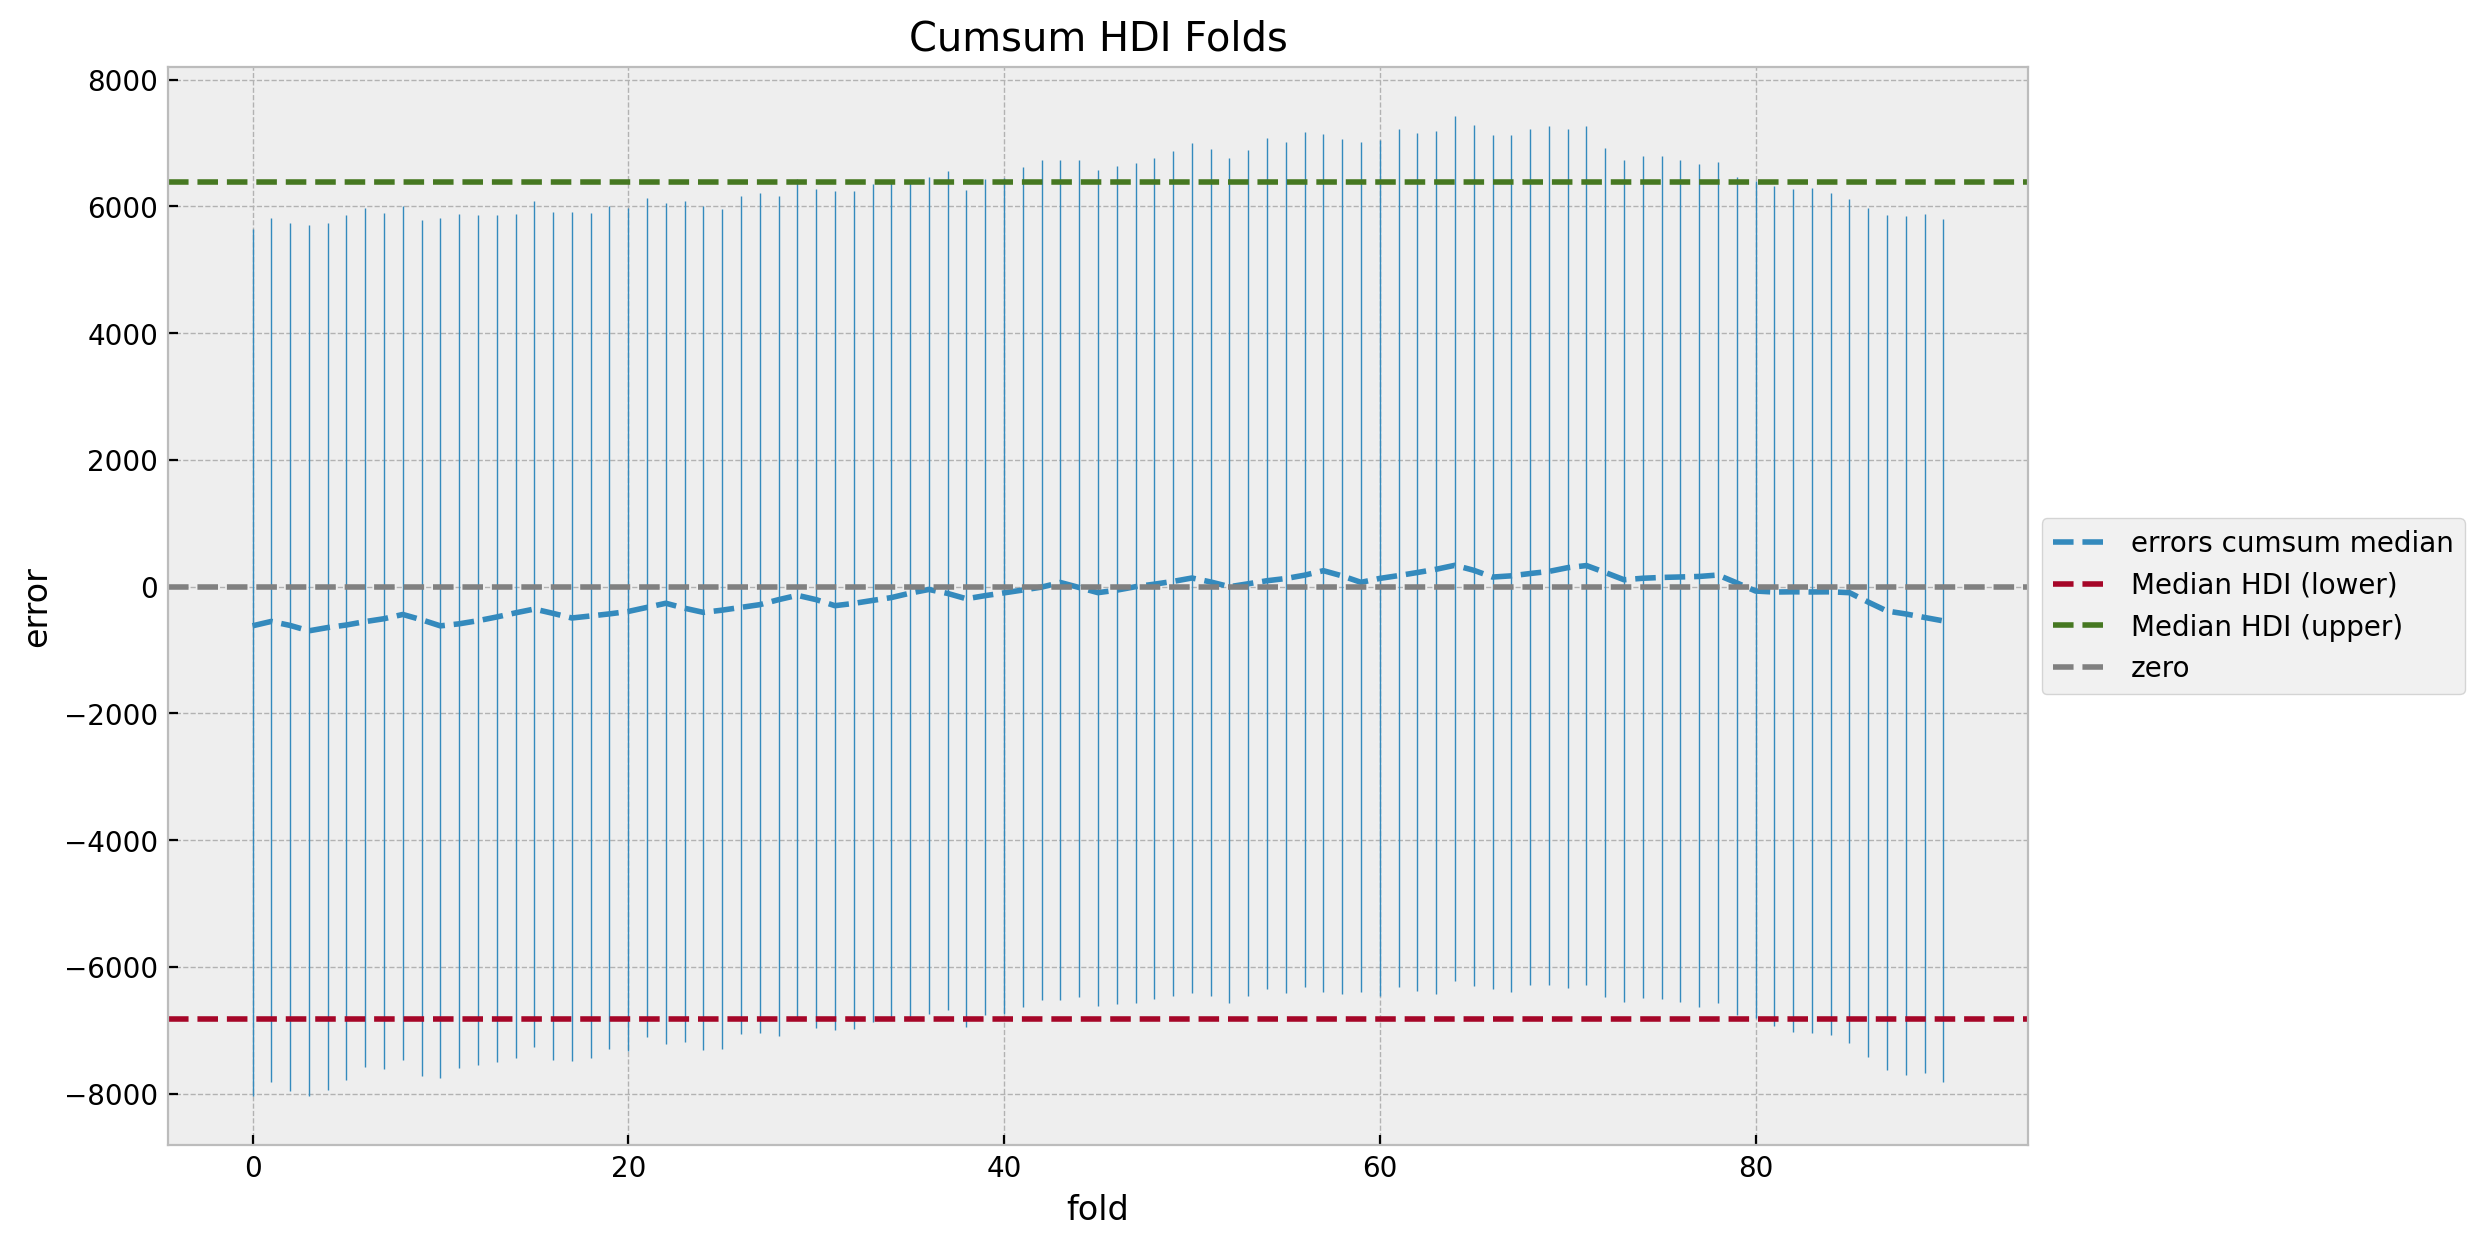

In [21]:
median_folds_errors_cumsum = np.median(folds_errors_cumsum.reshape(n_train, -1), axis=1)


fig, ax = plt.subplots()

for i in range(n_train):
    ax.vlines(
        x=i,
        ymin=folds_cumsum_hdi[i, 0],
        ymax=folds_cumsum_hdi[i, 1],
        linestyle="solid",
        linewidth=0.5,
    )
ax.plot(
    median_folds_errors_cumsum,
    color="C0",
    linestyle="dashed",
    label="errors cumsum median",
)
ax.axhline(
    y=folds_cumsum_hdi_median[0],
    color="C1",
    linestyle="dashed",
    label="Median HDI (lower)",
)
ax.axhline(
    y=folds_cumsum_hdi_median[1],
    color="C3",
    linestyle="dashed",
    label="Median HDI (upper)",
)
ax.axhline(y=0.0, color="gray", linestyle="--", label="zero")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Cumsum HDI Folds", xlabel="fold", ylabel="error");

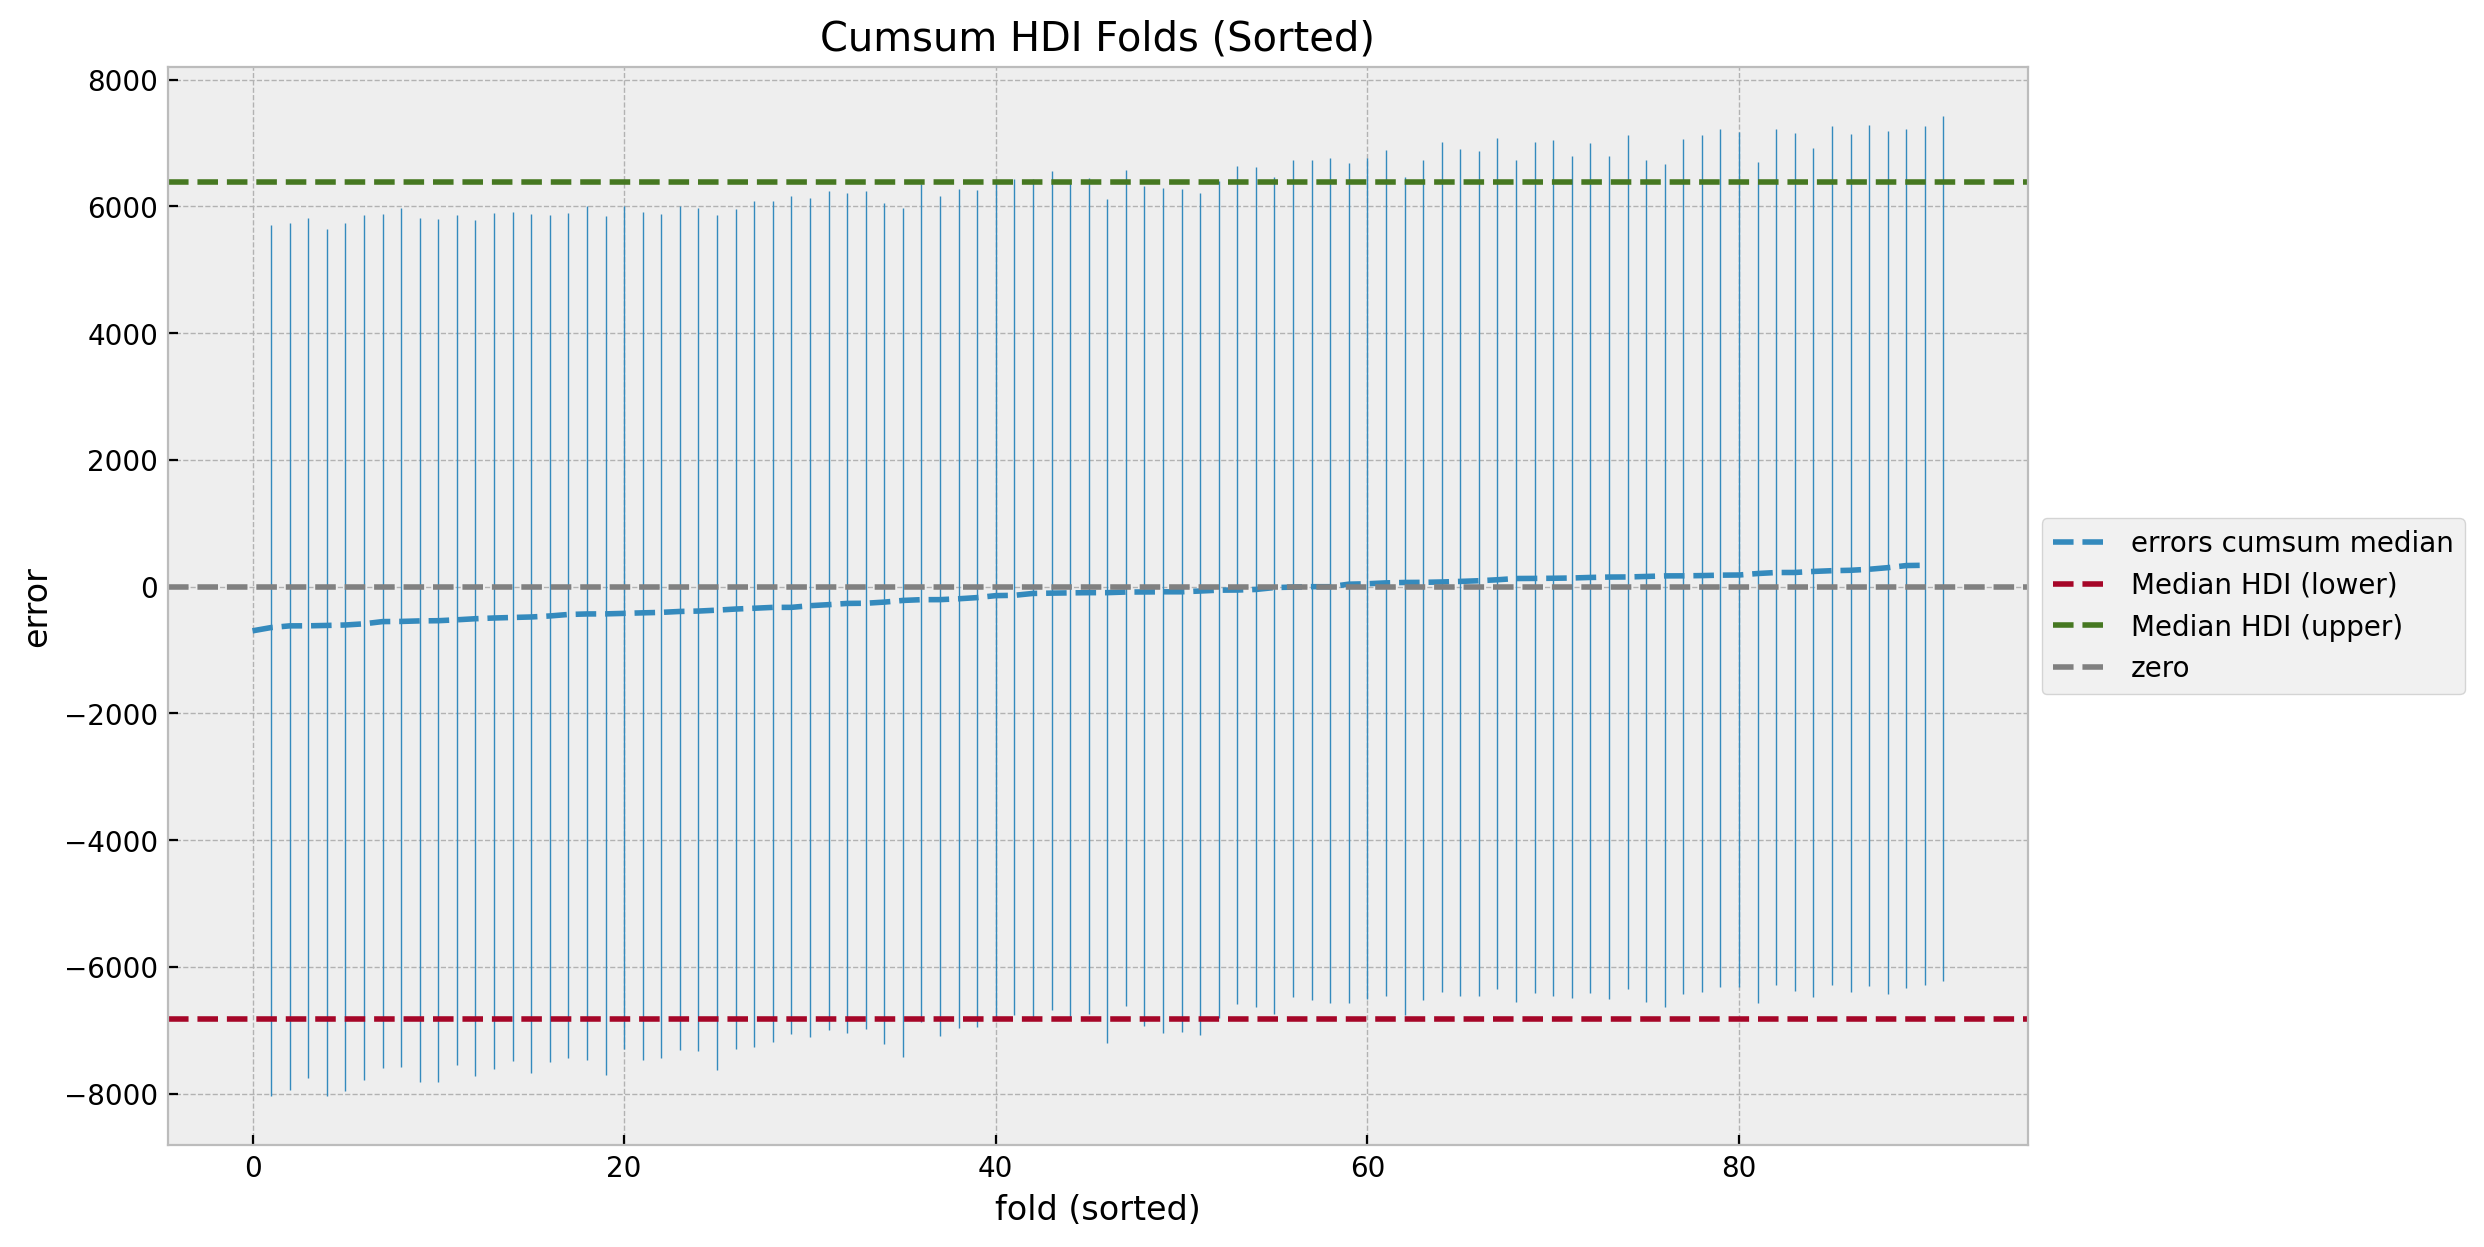

In [22]:
sorted_idx = np.argsort(a=median_folds_errors_cumsum)


fig, ax = plt.subplots()

for i in range(n_train):
    ymin = folds_cumsum_hdi[sorted_idx][i, 0]
    ymax = folds_cumsum_hdi[sorted_idx][i, 1]
    outside_condition = (ymin < folds_cumsum_hdi_median[0]) or (
        ymax > folds_cumsum_hdi_median[1]
    )
    ax.vlines(
        x=i + 1,
        ymin=ymin,
        ymax=ymax,
        color="C0",
        linestyle="solid",
        linewidth=0.5,
    )
ax.plot(
    median_folds_errors_cumsum[sorted_idx],
    color="C0",
    linestyle="dashed",
    label="errors cumsum median",
)
ax.axhline(
    y=folds_cumsum_hdi_median[0],
    color="C1",
    linestyle="dashed",
    label="Median HDI (lower)",
)
ax.axhline(
    y=folds_cumsum_hdi_median[1],
    color="C3",
    linestyle="dashed",
    label="Median HDI (upper)",
)
ax.axhline(y=0.0, color="gray", linestyle="--", label="zero")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Cumsum HDI Folds (Sorted)", xlabel="fold (sorted)", ylabel="error");

## Posterior Predictive (Test)

In [23]:
with model:
    pm.set_data(
        new_data={
            "y_control_data": y_control_test_scaled,
            "y_treatment_data": y_treatment_test_scaled,
        },
        coords={"date": date_test},
    )
    idata.extend(
        pm.sample_posterior_predictive(
            trace=idata,
            var_names=["likelihood", "mu"],
            idata_kwargs={"coords": {"date": date_test}},
        )
    )


Sampling: [likelihood]
INFO:pymc:Sampling: [likelihood]


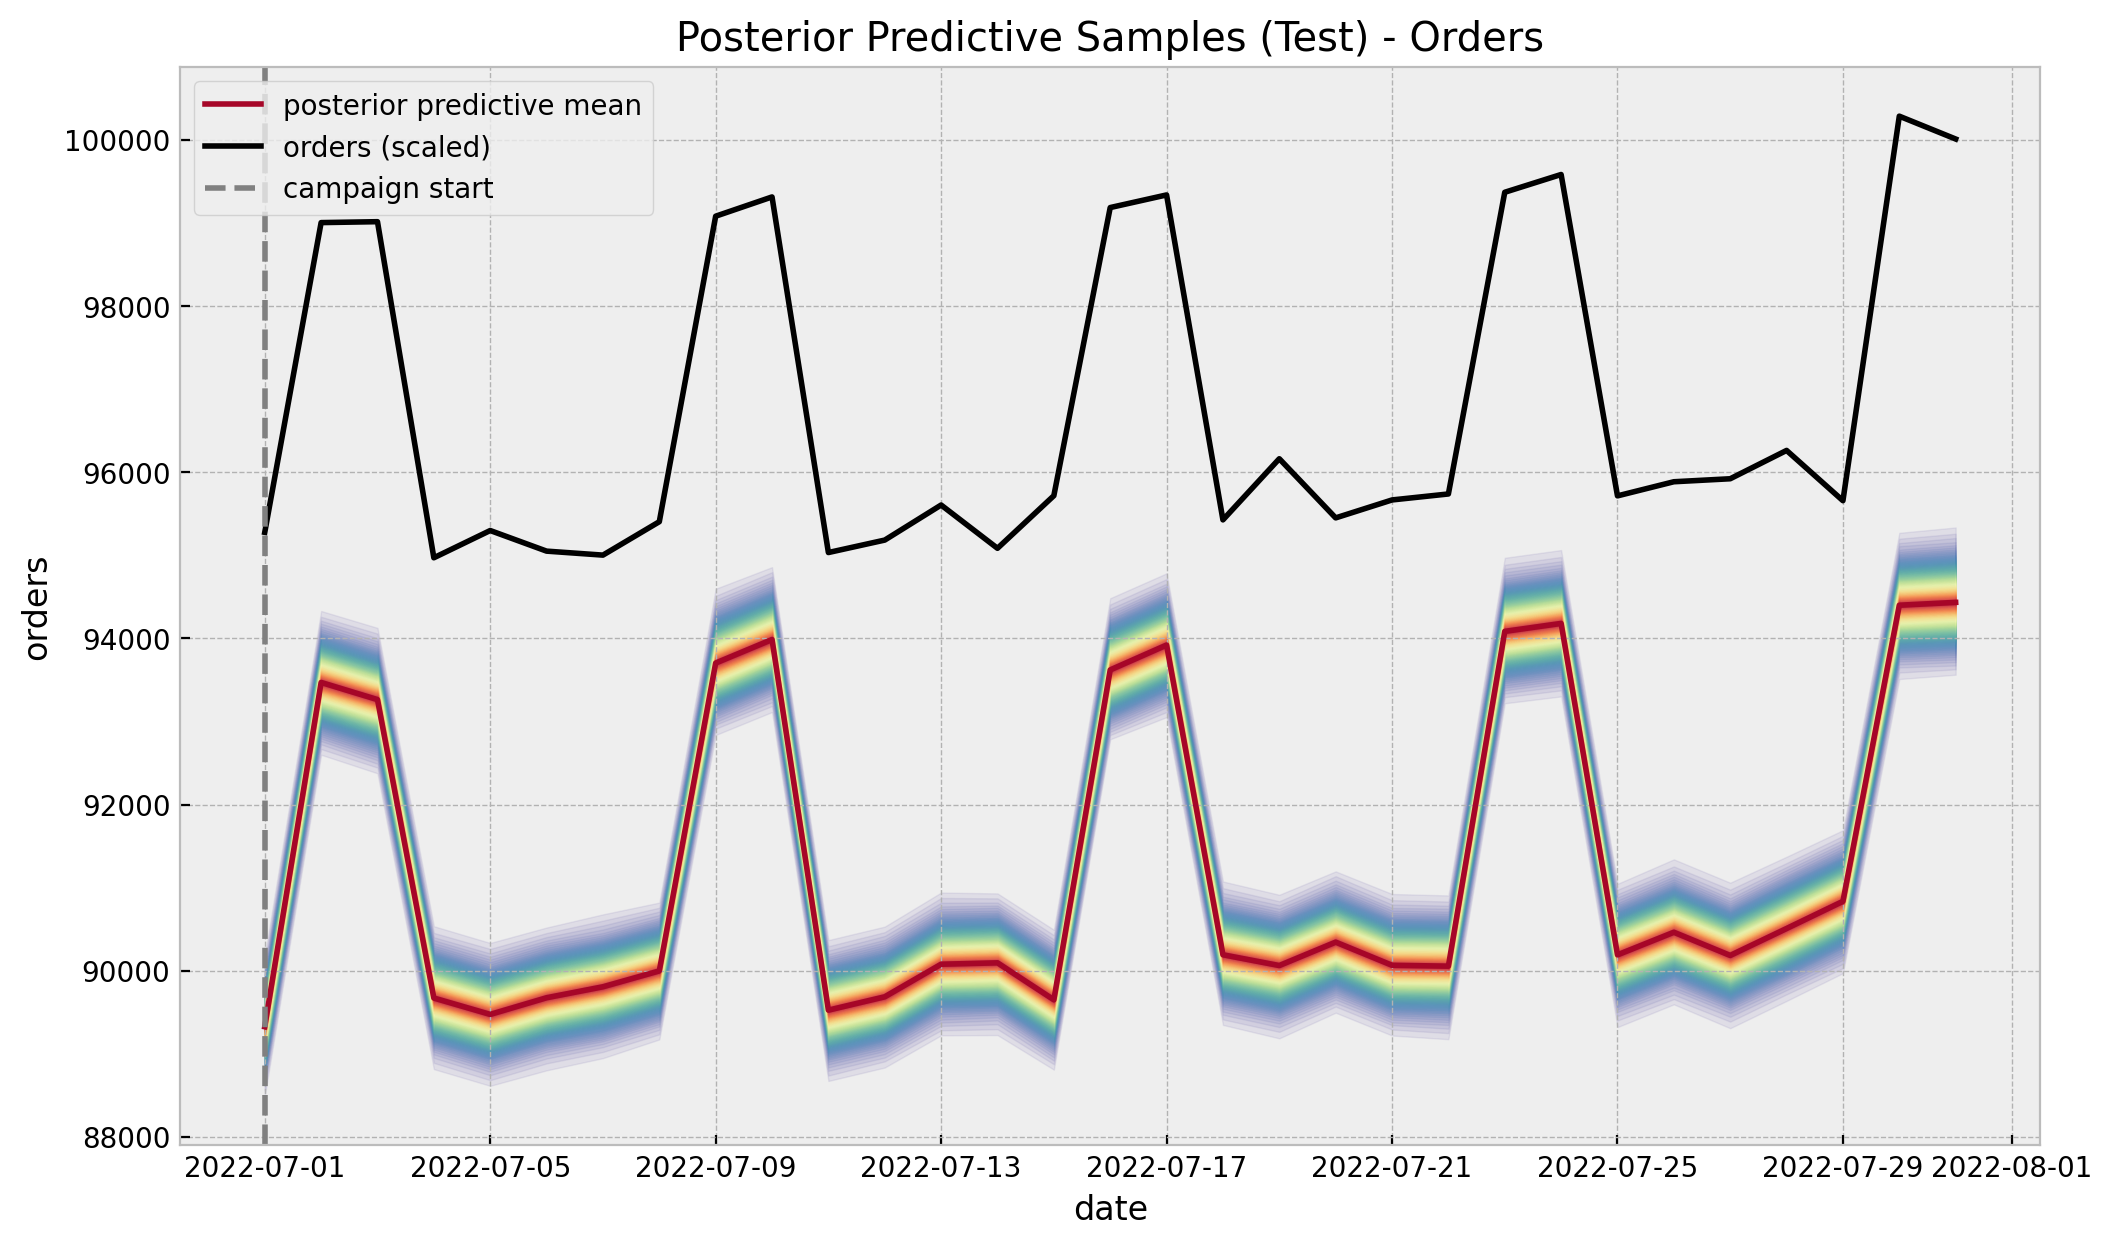

In [24]:
posterior_predictive_likelihood_test = az.extract(
    data=idata, group="posterior_predictive", var_names=["likelihood"]
)

posterior_predictive_likelihood_test_inv = scaler_treatment.inverse_transform(
    X=posterior_predictive_likelihood_test
)

fig, ax = plt.subplots()

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(a=posterior_predictive_likelihood_test_inv, q=p, axis=1)
    lower = np.percentile(a=posterior_predictive_likelihood_test_inv, q=100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=date_test,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=date_test,
    y=posterior_predictive_likelihood_test_inv.mean(axis=1),
    color="C1",
    label="posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=date_test,
    y=y_treatment_test,
    color="black",
    label="orders (scaled)",
    ax=ax,
)
ax.axvline(x=start_campaign, color="gray", linestyle="--", label="campaign start")
ax.legend(loc="upper left")
ax.set(
    title="Posterior Predictive Samples (Test) - Orders",
    xlabel="date",
    ylabel="orders",
);

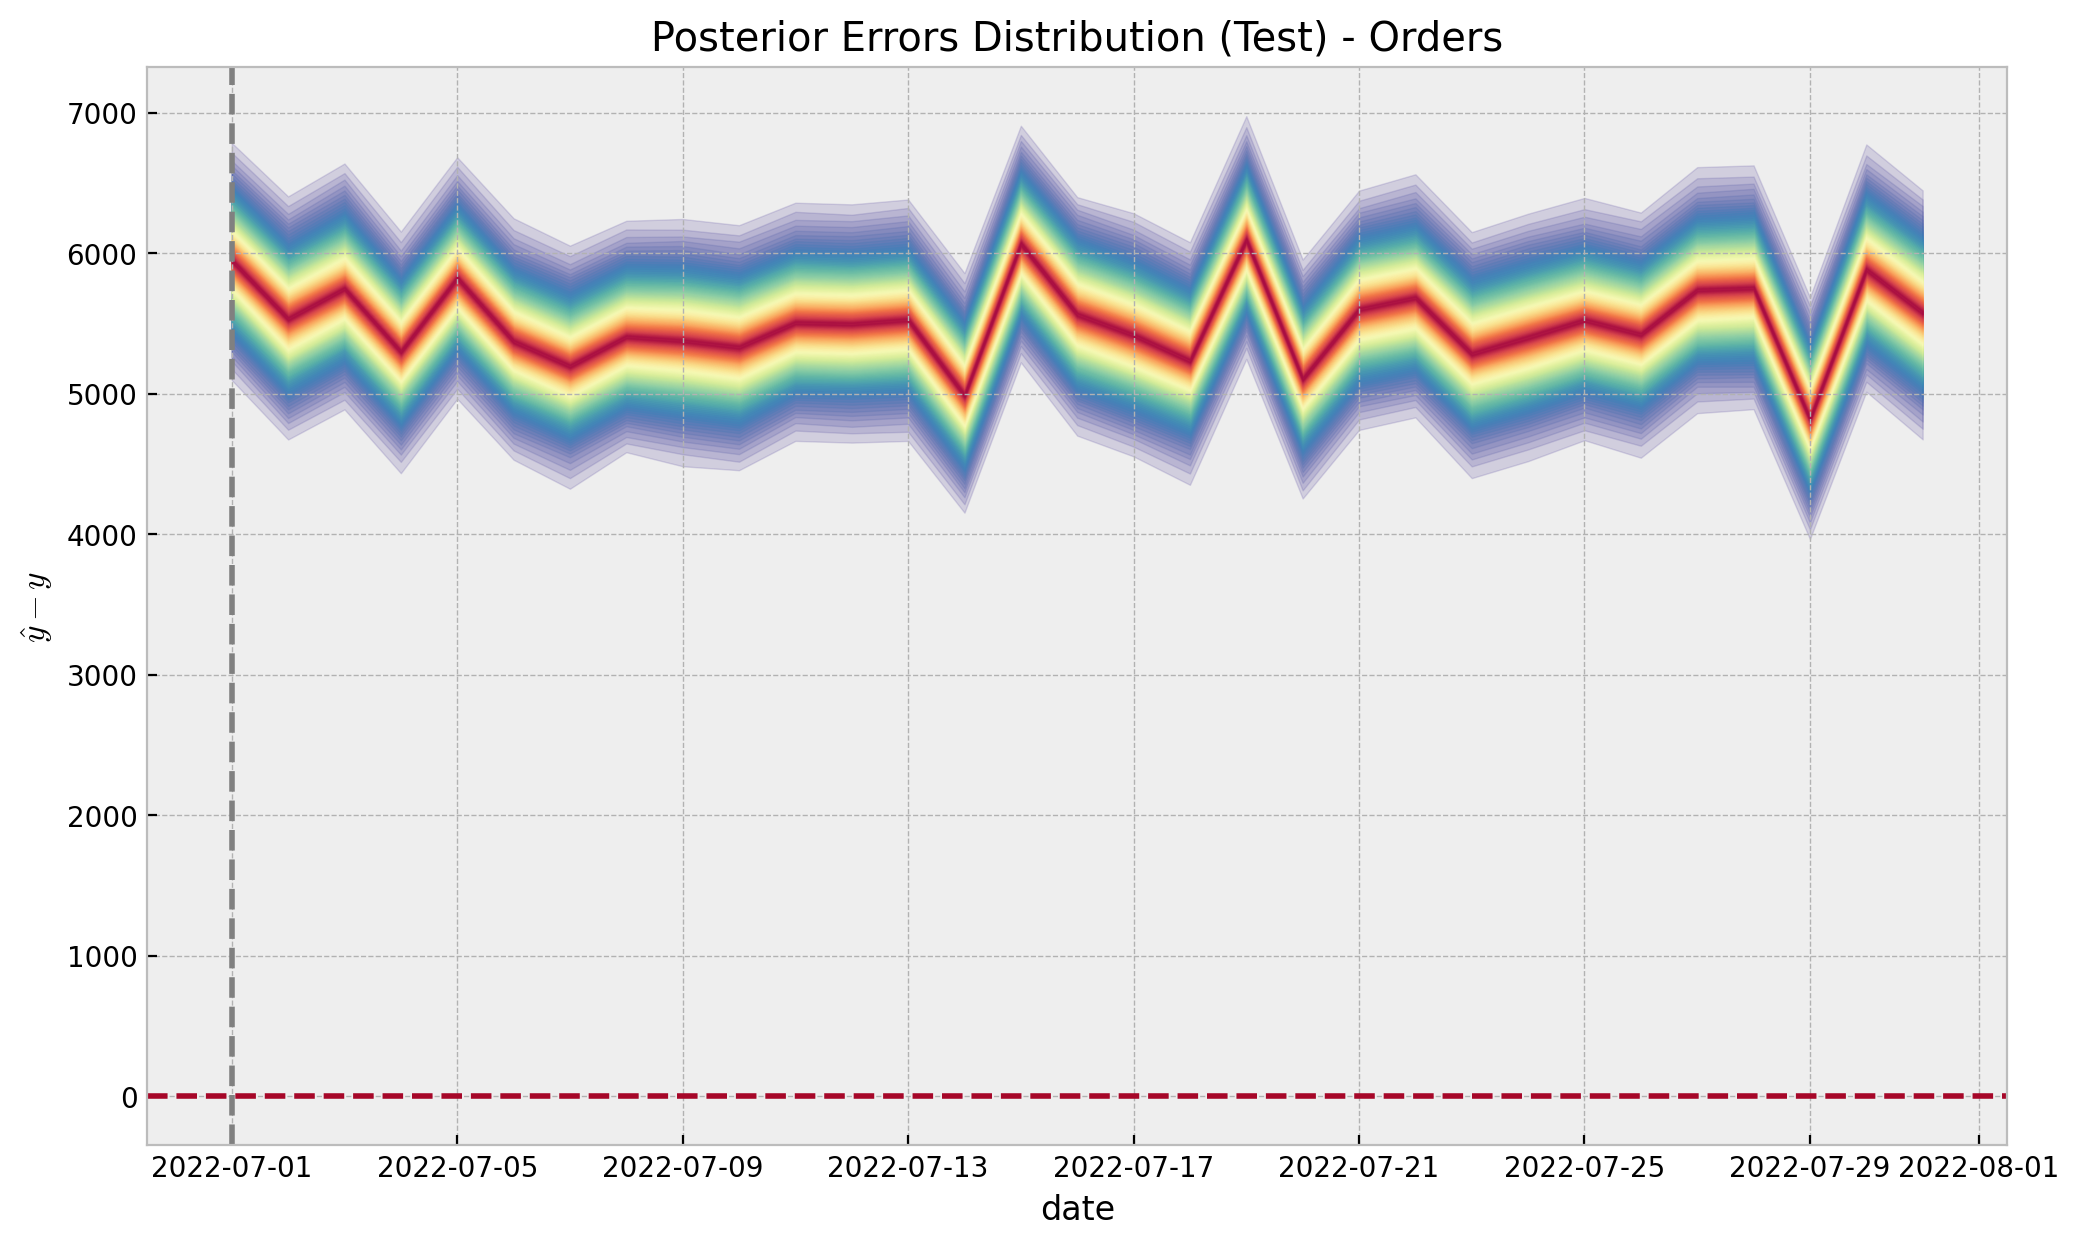

In [25]:
errors_test_inv = y_treatment_test[..., None] - posterior_predictive_likelihood_test_inv


fig, ax = plt.subplots()

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(a=errors_test_inv, q=p, axis=1)
    lower = np.percentile(a=errors_test_inv, q=100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(x=date_test, y1=upper, y2=lower, color=cmap(color_val), alpha=0.2)

ax.axhline(y=0, color="C1", linestyle="--")
ax.axvline(x=start_campaign, color="gray", linestyle="--", label="campaign start")
ax.set(
    title="Posterior Errors Distribution (Test) - Orders",
    xlabel="date",
    ylabel=r"$\hat{y} - y$",
);

/var/folders/4r/dzmwyydj3mbggyfwbs1cklvh0000gn/T/ipykernel_94162/869468218.py:2: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  errors_test_cumsum_hdi = az.hdi(ary=errors_test_cumsum.T)[-1, :]


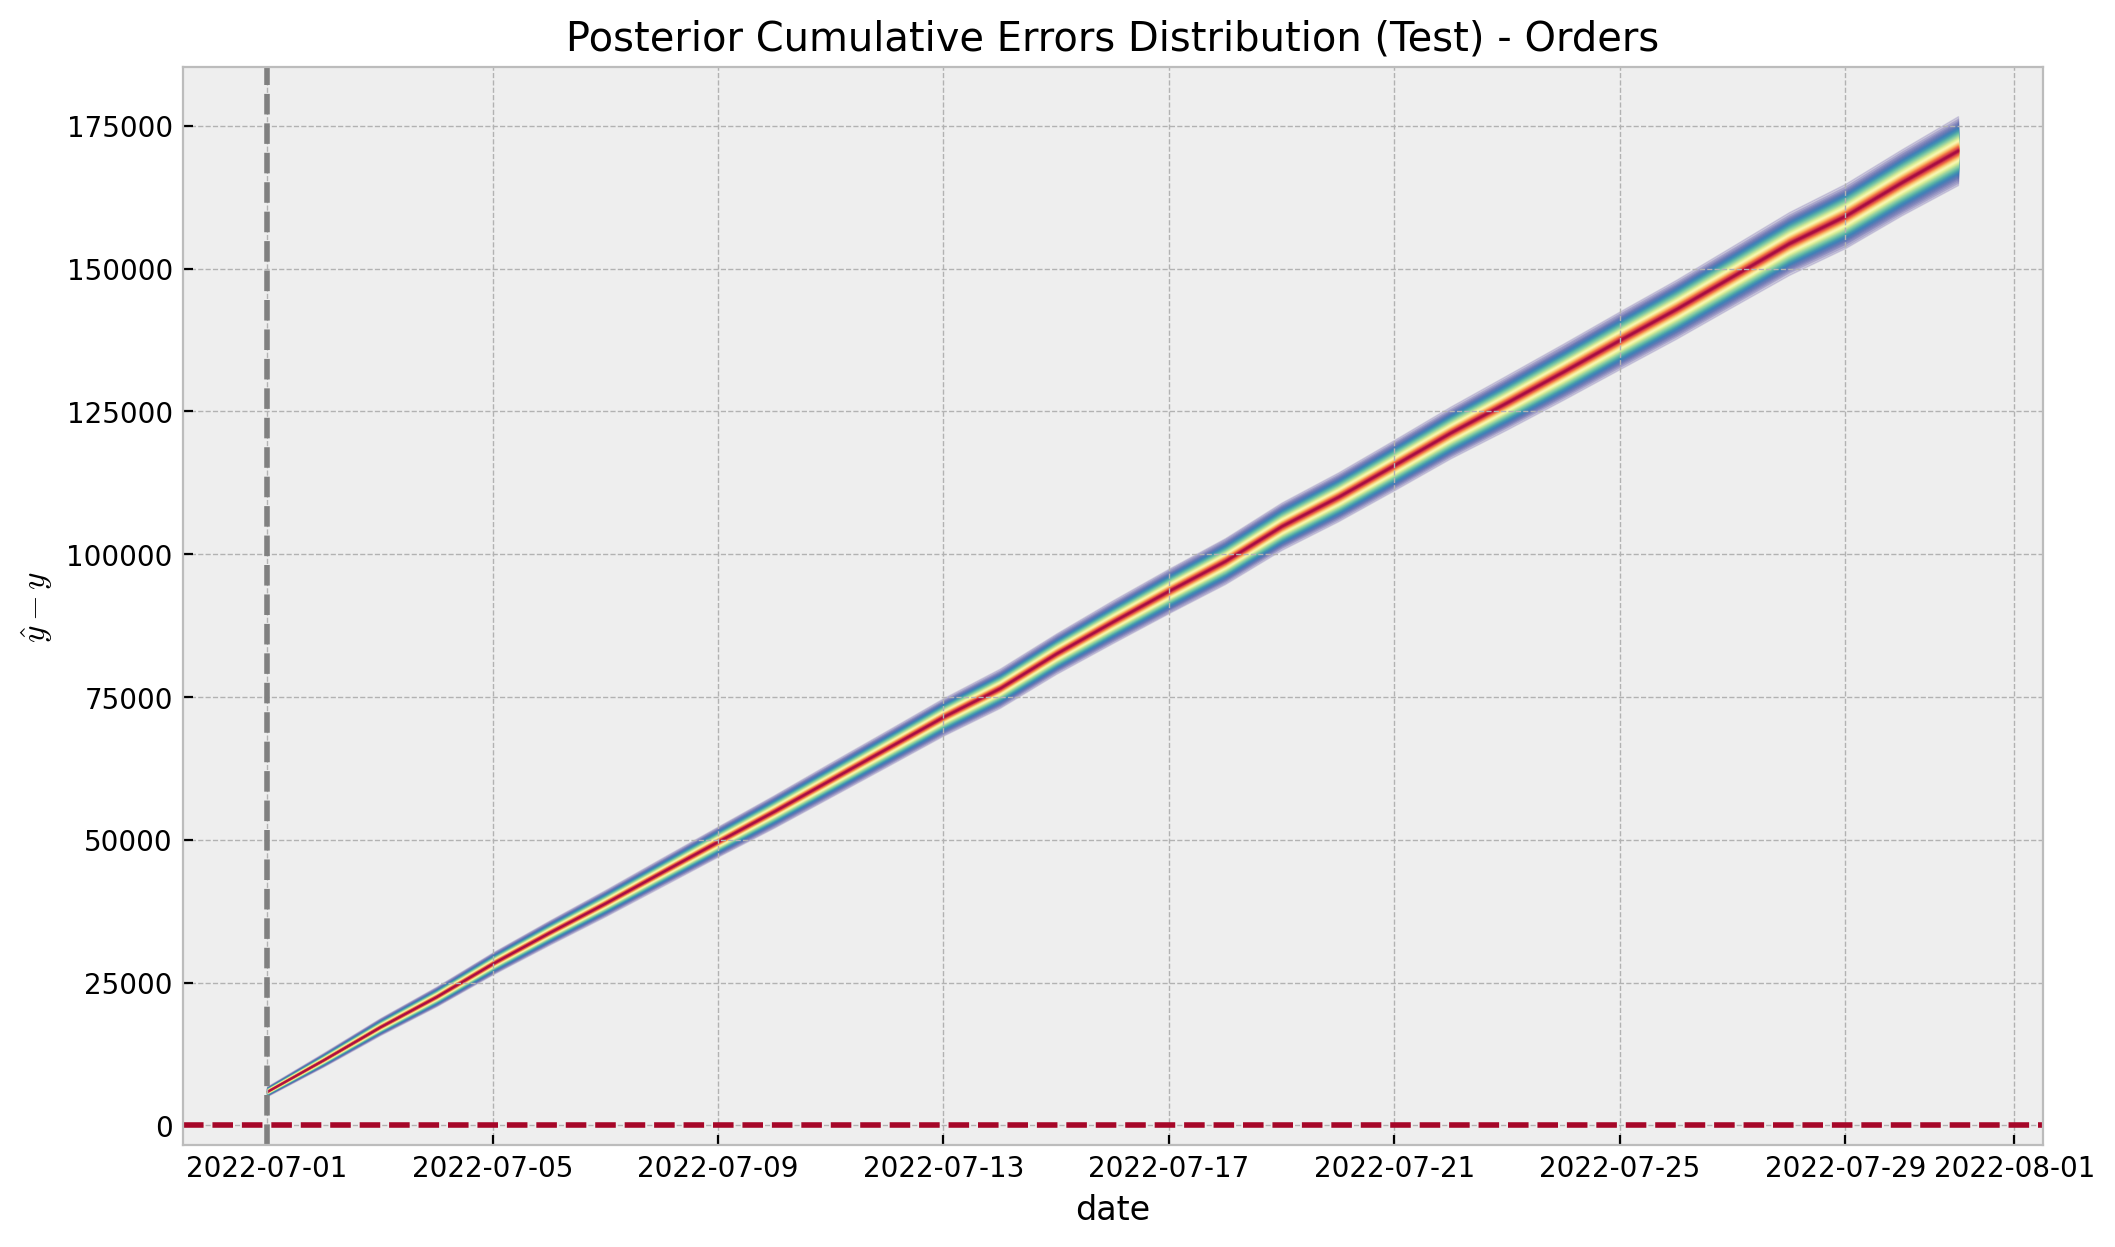

In [27]:
errors_test_cumsum = errors_test_inv.cumsum(axis=0)
errors_test_cumsum_hdi = az.hdi(ary=errors_test_cumsum.T)[-1, :]


fig, ax = plt.subplots()

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(a=errors_test_cumsum, q=p, axis=1)
    lower = np.percentile(a=errors_test_cumsum, q=100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(x=date_test, y1=upper, y2=lower, color=cmap(color_val), alpha=0.2)

ax.axhline(y=0, color="C1", linestyle="--")
ax.axvline(x=start_campaign, color="gray", linestyle="--", label="campaign start")
ax.set(
    title="Posterior Cumulative Errors Distribution (Test) - Orders",
    xlabel="date",
    ylabel=r"$\hat{y} - y$",
);